In [1]:
import numpy as np
import pandas as pd
import json
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import LSTM, Dense, Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.text import tokenizer_from_json

sequence_length = 13
# "/content/drive/MyDrive/Colab Notebooks/gpt/LEVX/i+d/model_llm.keras"
# "/content/drive/MyDrive/Colab Notebooks/gpt/LEVX/i+d/texts_test.csv"
# "/content/drive/MyDrive/Colab Notebooks/gpt/LEVX/i+d/tokenizer_config.json"
# /content/drive/MyDrive/metar/LECOmodel_llm.keras
#/content/drive/MyDrive/metar/LECOtokenizer_config.json
#/content/drive/MyDrive/Colab Notebooks/gpt/LECO/texts_test.csv

model_path = "/content/drive/MyDrive/Colab Notebooks/gpt/LECO/LECOmodel1.keras"
texts_test_path = "/content/drive/MyDrive/Colab Notebooks/gpt/LECO/LECOtexts_test1.csv"
tokenizer_path = "/content/drive/MyDrive/Colab Notebooks/gpt/LECO/LECOtokenizer_config1.json"
result_path = "/content/drive/MyDrive/Colab Notebooks/gpt/LECO/LECOresult1.csv"

model = load_model(model_path)
texts_test = pd.read_csv(texts_test_path, index_col="time").squeeze()

# Load the JSON configuration from the file
with open(tokenizer_path, 'r', encoding='utf-8') as f:
    tokenizer_json = json.load(f)

# Rebuild tokenizer from the JSON configuration
tokenizer = tokenizer_from_json(tokenizer_json)

In [2]:
#@title Get: X test, Y test and y_pred

sample = 300

# Function to generate text
def generate_text(seed_text, next_words=6):
    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=sequence_length, padding='pre')
        predicted_probs = model.predict(token_list,verbose=0)
        predicted_index = np.argmax(predicted_probs, axis=-1)[0]
        predicted_word = tokenizer.index_word[predicted_index]
        seed_text += " " + predicted_word
    return seed_text

def get_first_n_words(text, n):
    # Split the string into words
    words = text.split()
    # Join the first n words back into a string
    return ' '.join(words[:n])

def delete_first_n_words(text, n):
    # Split the string into words
    words = text.split()
    # Remove the first n words
    del words[:n]
    # Join the remaining words back into a string
    return ' '.join(words)

def delete_words_beyond_nosig(input_string):
    # Split the string into words
    words = input_string.split()
    # Find the index of "nosig" if it exists
    try:
        index_nosig = words.index("nosig")
    except ValueError:
        # If "nosig" is not found, return the original string
        return input_string
    # Keep only the words before "nosig"
    return ' '.join(words[:index_nosig + 1])


text_test = texts_test.sample(sample)

#texts_test.to_csv("/content/drive/MyDrive/Colab Notebooks/gpt/Levx/texts_test")

all_for_text = []
y_test = []
y_pred = []

for i in range(len(text_test)):
  all_for_text.append(generate_text(get_first_n_words(text_test[i],8),11))
  y_test.append(delete_first_n_words(text_test[i], 8))
  y_pred.append(delete_words_beyond_nosig(delete_first_n_words(all_for_text[i], 8)))

result = pd.DataFrame({"y_test":y_test,"y_pred":y_pred,"all":all_for_text})
result.index=text_test.index
result.to_csv(result_path)
result
for ind in range(0,len(result)):
  display(result.iloc[ind]["y_test"])
  display(result.iloc[ind]["y_pred"])
  display(result.iloc[ind]["all"])
  #display(result.iloc[ind]["all"])
  print("*********")

'28010KT 250V310 9999 VCSH SCT040TCU 12/04 Q0997 TEMPO SHRA'

'30009kt 260v010 9999 ra few025 sct039 09 07 q0994 tempo 3000'

'23013kt 9999 prec0n CL0 CM0 13 05 q0994 30009kt 260v010 9999 ra few025 sct039 09 07 q0994 tempo 3000'

*********


'01003KT 340V040 7000 RA FEW016 SCT025 BKN040 11/10 Q1010 TEMPO 3000'

'19009kt 160v240 9999 sct024 bkn029 14 10 q1011 nosig'

'20005kt 4000 prec0y CL6 CM5 15 10 q1011 19009kt 160v240 9999 sct024 bkn029 14 10 q1011 nosig bkn010 sct030cb'

*********


'17009KT 140V220 9999 -RA FEW022 SCT040 12/10 Q1005 TEMPO RA'

'19009kt 9999 few020 13 09 q1007 tempo ra bkn014 bkn030 10'

'21007kt 9999 prec0y CL0 CM0 13 10 q1003 19009kt 9999 few020 13 09 q1007 tempo ra bkn014 bkn030 10'

*********


'20012KT 160V240 9999 BKN021 BKN027 24/20 Q1015 NOSIG'

'9999 300v080 9999 few035 24 15 q1015 nosig'

'20011kt 9999 prec0n CL0 CM0 24 19 q1015 9999 300v080 9999 few035 24 15 q1015 nosig nosig fg bkn003'

*********


'20004KT 160V240 3000 -RA SCT011 BKN018 12/11 Q1013 NOSIG'

'27006kt 9999 bkn040 12 10 q1012 nosig'

'26007kt 9999 prec0n CL5 CM1 12 11 q1012 27006kt 9999 bkn040 12 10 q1012 nosig nosig bkn010 bkn030 16'

*********


'23009KT 200V260 9999 FEW035 17/11 Q1018 NOSIG'

'17004kt 9999 few030 15 13 q1016 nosig'

'24005kt 9999 prec0n CL0 CM2 16 11 q1017 17004kt 9999 few030 15 13 q1016 nosig 17008kt tempo 3000 radz'

*********


'22003KT 190V250 9999 FEW025 SCT048 15/14 Q1021 NOSIG'

'21005kt 9999 few021 bkn041 bkn043 15 14 q1021 nosig'

'23005kt 9999 prec0y CL3 CM0 14 13 q1021 21005kt 9999 few021 bkn041 bkn043 15 14 q1021 nosig nosig 3000'

*********


'22011KT 9999 FEW034 BKN042 24/12 Q1014 NOSIG'

'24008kt 200v260 9999 few048 23 14 q1014 nosig'

'23011kt 9999 prec0n CL3 CM0 22 14 q1014 24008kt 200v260 9999 few048 23 14 q1014 nosig ra nsc 20'

*********


'19019G36KT 160V220 9999 -RA BKN021 12/10 Q1007 TEMPO 3000 RA'

'22017kt 190v250 9999 ra few026 bkn043 14 13 q1009 tempo 3000'

'19023kt 7000 prec0y CL0 CM2 14 11 q1008 22017kt 190v250 9999 ra few026 bkn043 14 13 q1009 tempo 3000'

*********


'VRB01KT CAVOK 11/11 Q1012 NOSIG'

'vrb02kt cavok 12 10 q1011 nosig'

'14003kt 9999 prec0n CL0 CM0 10 10 q1013 vrb02kt cavok 12 10 q1011 nosig ncd 18 15 q1009 nosig'

*********


'16013KT 100V190 9999 FEW025 SCT030TCU 19/12 Q1002 TEMPO 3000 SHRA SCT030TCU'

'19008kt 150v230 9999 few030 18 13 q1004 nosig'

'15009kt 9999 prec0n CL0 CM2 18 13 q1003 19008kt 150v230 9999 few030 18 13 q1004 nosig 4000 shra sct025tcu'

*********


'01008KT 310V070 9999 FEW027 22/15 Q1020 NOSIG'

'02008kt 320v070 9999 few030 22 16 q1020 nosig'

'33007kt 9999 prec0n CL0 CM0 22 16 q1020 02008kt 320v070 9999 few030 22 16 q1020 nosig nosig 1500 ra'

*********


'17006KT CAVOK 05/05 Q1021'

'21005kt 9999 few045 05 03 q1022 nosig'

'20007kt 9999 prec0n CL0 CM4 08 05 q1022 21005kt 9999 few045 05 03 q1022 nosig tempo 3000 shra few008'

*********


'01003KT 320V050 9999 VCTS BKN033 BKN041 ///CB 07/04 Q1002'

'17006kt 9999 few030 sct040 06 05 q1002 tempo 3000 shra sct025tcu'

'25007kt 9999 prec0n CL0 CM0 08 05 q1003 17006kt 9999 few030 sct040 06 05 q1002 tempo 3000 shra sct025tcu'

*********


'VRB07KT 9999 SCT035 BKN042 17/11 Q1021'

'vrb05kt 9999 few045 18 12 q1021 nosig'

'28015kt 9999 prec0n CL2 CM0 20 13 q1020 vrb05kt 9999 few045 18 12 q1021 nosig nosig 3000 ra bkn010'

*********


'00000KT 9999 FEW010 BKN030 17/16 Q1024 NOSIG'

'vrb01kt cavok 16 13 q1025 nosig'

'24001kt 9999 prec0n CL0 CM0 14 14 q1025 vrb01kt cavok 16 13 q1025 nosig nosig nosig 1500 br dz'

*********


'19019G29KT 130V240 CAVOK 22/07 Q1020 NOSIG'

'18017g28kt 150v250 cavok 19 05 q1019 nosig'

'19019kt 9999 prec0n CL0 CM0 19 10 q1019 18017g28kt 150v250 cavok 19 05 q1019 nosig 16010kt bkn012 bkn020 18'

*********


'02009KT 320V070 CAVOK 19/11 Q1019'

'35010kt 300v050 9999 few030 19 13 q1018 nosig'

'36011kt 9999 prec0n CL2 CM3 19 12 q1019 35010kt 300v050 9999 few030 19 13 q1018 nosig nosig rera tempo'

*********


'VRB02KT 9000 SCT010 OVC017 16/15 Q1016'

'vrb02kt 9999 few030 bkn040 16 16 q1016 nosig'

'34001kt 9999 prec0n CL3 CM2 14 14 q1016 vrb02kt 9999 few030 bkn040 16 16 q1016 nosig 3000 shra sct030tcu'

*********


'18003KT 9000 R21/P2000 R03/1300D VCFG NSC 04/04 Q1021 TEMPO 0800 FG'

'18004kt 0150 r21 0500n r03 0350n fg vv001 03 03 q1021'

'14003kt 9999 prec0n CL0 CM0 06 05 q1022 18004kt 0150 r21 0500n r03 0350n fg vv001 03 03 q1021'

*********


'23006KT CAVOK 13/09 Q1018 NOSIG'

'23008kt cavok 14 12 q1017 nosig'

'23009kt 9999 prec0n CL0 CM0 13 11 q1017 23008kt cavok 14 12 q1017 nosig nosig 1500 bcfg bkn003 ovc010'

*********


'23007KT 9999 FEW042 14/11 Q1020 NOSIG'

'24006kt 200v270 9999 few020 bkn032 14 10 q1020 nosig'

'23007kt 9999 prec0n CL0 CM0 14 10 q1020 24006kt 200v270 9999 few020 bkn032 14 10 q1020 nosig 3000 ra'

*********


'04007KT 010V080 9999 FEW040 22/16 Q1017 NOSIG'

'21005kt 170v240 cavok 21 13 q1018 nosig'

'26007kt 9999 prec0n CL0 CM2 24 14 q1019 21005kt 170v240 cavok 21 13 q1018 nosig q1020 nosig 3000 ra'

*********


'01006KT 300V070 CAVOK 26/19 Q1015 NOSIG'

'36008kt 300v050 cavok 26 18 q1015 nosig'

'02011kt 9999 prec0n CL0 CM0 26 19 q1015 36008kt 300v050 cavok 26 18 q1015 nosig nosig 1500 shra sct020cb'

*********


'33003KT 290V020 CAVOK 16/13 Q1023 NOSIG'

'01008kt 320v060 9999 few030 15 09 q1025 nosig'

'01007kt 9999 prec0n CL0 CM0 14 11 q1026 01008kt 320v060 9999 few030 15 09 q1025 nosig nosig nosig 3000'

*********


'36005KT 290V050 9999 FEW035 17/15 Q1021 NOSIG'

'36004kt 320v070 cavok 17 13 q1022 nosig'

'02007kt 9999 prec0n CL0 CM0 15 14 q1022 36004kt 320v070 cavok 17 13 q1022 nosig 1500 bcfg bkn005 bkn010'

*********


'VRB01KT CAVOK 20/18 Q1013'

'00000kt 4400 br ovc003 20 19 q1013 nosig'

'00001kt 500 prec0n CL5 CM0 18 18 q1014 00000kt 4400 br ovc003 20 19 q1013 nosig 4000 ra bkn005'

*********


'21009KT 170V250 9999 FEW030 BKN048 15/10 Q1028 NOSIG'

'20009kt 150v270 9999 sct028 13 11 q1028 nosig'

'21011kt 9999 prec0n CL0 CM0 15 11 q1028 20009kt 150v270 9999 sct028 13 11 q1028 nosig 15013kt 18 15'

*********


'01003KT 330V060 9999 FEW020 19/16 Q1019 NOSIG'

'00000kt 9999 few012 ovc017 18 17 q1019 nosig'

'31003kt 9999 prec0n CL2 CM0 17 17 q1019 00000kt 9999 few012 ovc017 18 17 q1019 nosig nosig 3000 radz'

*********


'17005KT 9999 0300E R21/P2000 R03/0800N PRFG NSC 10/10 Q1028 NOSIG'

'vrb01kt 9000 vcfg nsc 10 10 q1029 nosig'

'17003kt 9999 prec0n CL0 CM0 11 10 q1029 vrb01kt 9000 vcfg nsc 10 10 q1029 nosig 27003kt bkn007 sct025cb'

*********


'14003KT 110V170 CAVOK 18/17 Q1014 NOSIG'

'11003kt 070v170 9999 few007 17 13 q1015 nosig'

'12003kt 9999 prec0n CL0 CM0 18 13 q1014 11003kt 070v170 9999 few007 17 13 q1015 nosig nsw bkn025 17'

*********


'17005KT 120V210 CAVOK 24/17 Q1016 NOSIG'

'vrb02kt cavok 26 18 q1017 nosig'

'10005kt 9999 prec0n CL0 CM0 27 18 q1018 vrb02kt cavok 26 18 q1017 nosig nosig nosig 24 19 17'

*********


'10004KT 040V160 9999 FEW030 13/03 Q1020 NOSIG'

'vrb01kt cavok 10 02 q1022 nosig'

'10007kt 9999 prec0n CL0 CM1 12 02 q1022 vrb01kt cavok 10 02 q1022 nosig nosig 1500 bcfg bkn006 bkn010'

*********


'04007KT 350V070 9999 FEW030 18/13 Q1024 NOSIG'

'vrb02kt 9999 ovc015 15 13 q1023 nosig'

'03003kt 9999 prec0n CL1 CM0 16 13 q1025 vrb02kt 9999 ovc015 15 13 q1023 nosig 1500 bcfg bkn004 bkn010'

*********


'34021G33KT 310V030 9999 SCT042 09/04 Q1007'

'32013g24kt 250v020 9999 few030 sct045 10 05 q1008 nosig'

'31011kt 9999 prec0y CL1 CM2 10 06 q1006 32013g24kt 250v020 9999 few030 sct045 10 05 q1008 nosig 32012kt shra'

*********


'03005KT 330V080 9999 FEW025 11/07 Q1028 NOSIG'

'02004kt 330v060 9999 bkn040 12 07 q1028 nosig'

'03003kt 9999 prec0n CL3 CM0 10 07 q1030 02004kt 330v060 9999 bkn040 12 07 q1028 nosig 24011kt tempo ra'

*********


'VRB02KT 0400 R21/1100U R03/1000U FG VV001 04/04 Q1032 NOSIG'

'03005kt 350v070 9999 few010 sct015 10 09 q1031 nosig'

'10001kt 500 prec0n CL0 CM0 09 08 q1033 03005kt 350v070 9999 few010 sct015 10 09 q1031 nosig 27009g19kt tempo'

*********


'VRB01KT 9000 OVC007 17/16 Q1022 BECMG NSC'

'00000kt 7000 3000e bcfg nsc 16 16 q1020 nosig'

'02001kt 500 prec0n CL0 CM0 16 15 q1021 00000kt 7000 3000e bcfg nsc 16 16 q1020 nosig 3000 br'

*********


'24011KT 210V270 9999 FEW024 BKN047 16/14 Q1019 TEMPO 3000 RA'

'21010kt 170v240 9999 bkn019 ovc022 15 14 q1020 tempo 4000 ra'

'22009kt 9999 prec0n CL3 CM0 15 12 q1019 21010kt 170v240 9999 bkn019 ovc022 15 14 q1020 tempo 4000 ra'

*********


'19017G30KT 140V220 CAVOK 16/12 Q1011'

'24008kt 210v280 9999 ra few040 14 13 q1010 tempo 4000 ra'

'19021kt 9999 prec0y CL2 CM4 15 12 q1010 24008kt 210v280 9999 ra few040 14 13 q1010 tempo 4000 ra'

*********


'00000KT CAVOK 19/16 Q1017 NOSIG'

'vrb02kt 9999 ovc015 17 14 q1016 nosig'

'32001kt 9999 prec0n CL1 CM0 16 15 q1017 vrb02kt 9999 ovc015 17 14 q1016 nosig 3000 shra sct030tcu 18'

*********


'19004KT 0100 R21/0350N R03/0350N FG VV001 05/05 Q1022 NOSIG'

'17004kt cavok 05 05 q1022 nosig'

'18003kt 9999 prec0n CL0 CM0 06 05 q1023 17004kt cavok 05 05 q1022 nosig nosig 1500 bcfg bkn014 bkn020'

*********


'04003KT 010V070 CAVOK 07/02 Q1020 NOSIG'

'05005kt 9999 ncd 07 03 q1021 tempo shra sct025tcu bkn032 10'

'05005kt 8000 prec0y CL9 CM0 07 05 q1022 05005kt 9999 ncd 07 03 q1021 tempo shra sct025tcu bkn032 10'

*********


'01004KT 300V060 9999 SCT030 18/15 Q1021 NOSIG'

'vrb02kt cavok 16 13 q1021 nosig'

'35003kt 9999 prec0n CL0 CM0 14 14 q1022 vrb02kt cavok 16 13 q1021 nosig nosig 1500 bcfg bkn010 17'

*********


'17006KT 140V210 9999 FEW046 12/10 Q1018'

'23011kt 200v260 9999 sct025 14 11 q1017 nosig'

'21011kt 9999 prec0n CL5 CM5 14 10 q1016 23011kt 200v260 9999 sct025 14 11 q1017 nosig nosig dz bkn010'

*********


'16006KT CAVOK 19/18 Q1006 NOSIG'

'19015kt 9999 bkn021 19 17 q1005 tempo shra sct035tcu few040cb 18'

'11003kt 9999 prec0n CL0 CM2 18 17 q1006 19015kt 9999 bkn021 19 17 q1005 tempo shra sct035tcu few040cb 18'

*********


'15008KT CAVOK 05/01 Q1023 NOSIG'

'17008kt cavok 04 02 q1025 nosig'

'16007kt 9999 prec0n CL0 CM0 08 03 q1024 17008kt cavok 04 02 q1025 nosig tempo 3000 br bkn010 01'

*********


'22006KT 160V280 9999 FEW020 15/10 Q1016 TEMPO SHRA SCT030TCU'

'28008kt 230v330 9999 sct034 13 08 q1015 nosig'

'25009kt 9999 prec0n CL0 CM2 14 09 q1015 28008kt 230v330 9999 sct034 13 08 q1015 nosig shra sct020tcu sct030cb'

*********


'35015KT 320V030 9999 FEW026 16/12 Q1025 NOSIG'

'01008kt 320v050 9999 few022 19 13 q1025 nosig'

'35009kt 9999 prec0n CL0 CM0 17 12 q1026 01008kt 320v050 9999 few022 19 13 q1025 nosig q1026 nosig bkn012'

*********


'22012KT 9999 SCT044 10/07 Q1018'

'27012g22kt 9999 ra sct017 sct027 10 09 q1019 tempo ra bkn010'

'27013kt 9999 prec0y CL2 CM1 12 10 q1018 27012g22kt 9999 ra sct017 sct027 10 09 q1019 tempo ra bkn010'

*********


'21003KT 150V250 9999 BKN024 17/15 Q1023 NOSIG'

'00000kt 9999 few018 16 16 q1023 nosig'

'26003kt 9999 prec0n CL3 CM0 16 14 q1023 00000kt 9999 few018 16 16 q1023 nosig q1023 nosig bcfg bkn020'

*********


'05004KT CAVOK 09/05 Q1026 NOSIG'

'00000kt 9999 sct030 10 08 q1030 nosig'

'04003kt 9999 prec0n CL1 CM0 08 07 q1030 00000kt 9999 sct030 10 08 q1030 nosig q1030 tempo 3000 ra'

*********


'34004KT 280V030 9999 SCT010 BKN016 16/14 Q1017 NOSIG'

'vrb02kt 9999 ovc010 15 13 q1018 nosig'

'30005kt 9999 prec0n CL4 CM0 15 15 q1018 vrb02kt 9999 ovc010 15 13 q1018 nosig 30011g22kt br bkn003 bkn010'

*********


'28005KT 240V320 9000 SCT035 SCT045 16/14 Q1021 NOSIG'

'28007kt 240v330 9999 bkn025 17 15 q1019 nosig'

'27011kt 9999 prec0n CL2 CM0 16 13 q1019 28007kt 240v330 9999 bkn025 17 15 q1019 nosig nosig 1500 bcfg'

*********


'18010KT 9999 FEW040 09/07 Q1020 NOSIG'

'18011kt 9999 few016 sct022 10 09 q1019 nosig'

'19011kt 9999 prec0n CL0 CM0 11 08 q1019 18011kt 9999 few016 sct022 10 09 q1019 nosig 3000 shra sct030tcu'

*********


'03007KT CAVOK 30/20 Q1017 NOSIG'

'02008kt 350v060 cavok 27 18 q1017 nosig'

'31007kt 9999 prec0n CL0 CM0 31 21 q1018 02008kt 350v060 cavok 27 18 q1017 nosig nosig 8000 vv001 bkn038'

*********


'18008KT 140V200 CAVOK 12/11 Q1007'

'14003kt 280v070 9999 few030 13 09 q1008 nosig'

'10007kt 9999 prec0n CL1 CM0 12 10 q1006 14003kt 280v070 9999 few030 13 09 q1008 nosig 3000 shra sct030tcu'

*********


'20010KT 170V240 9999 BKN038 24/16 Q1019 NOSIG'

'vrb04kt 9999 ra sct018 sct035 21 18 q1019 tempo 3000 ra'

'23011kt 9999 prec0n CL2 CM0 26 16 q1019 vrb04kt 9999 ra sct018 sct035 21 18 q1019 tempo 3000 ra'

*********


'VRB01KT 6000 OVC007 12/11 Q1019 NOSIG'

'vrb02kt 9999 few030 sct044 15 10 q1019 nosig'

'30005kt 9999 prec0n CL0 CM0 16 11 q1019 vrb02kt 9999 few030 sct044 15 10 q1019 nosig nosig 3000 ra'

*********


'16008KT 9999 SCT030 12/12 Q1020 NOSIG'

'21010kt 180v250 9999 few020 sct034 bkn040 14 11 q1020 nosig'

'20011kt 9999 prec0n CL8 CM7 14 11 q1020 21010kt 180v250 9999 few020 sct034 bkn040 14 11 q1020 nosig nosig'

*********


'04006KT 330V080 9999 FEW030 08/01 Q1013 NOSIG'

'04007kt 010v070 9999 few040 09 03 q1016 nosig'

'03007kt 9999 prec0n CL0 CM0 09 04 q1016 04007kt 010v070 9999 few040 09 03 q1016 nosig shra sct030tcu sct030cb'

*********


'17004KT 6000 FEW005 17/16 Q1014'

'17009kt 140v200 9999 few030 19 15 q1015 nosig'

'14001kt 9999 prec0n CL0 CM2 17 15 q1014 17009kt 140v200 9999 few030 19 15 q1015 nosig nosig 3000 shra'

*********


'02008KT 340V080 9999 FEW026 19/12 Q1025 NOSIG'

'01007kt 320v060 cavok 21 13 q1024 nosig'

'35007kt 9999 prec0n CL0 CM0 21 12 q1025 01007kt 320v060 cavok 21 13 q1024 nosig nosig nosig nosig 17'

*********


'17006KT CAVOK 06/04 Q1020 NOSIG'

'17004kt cavok 09 09 q1021 nosig'

'15005kt 9999 prec0n CL0 CM0 10 07 q1022 17004kt cavok 09 09 q1021 nosig 1500 bcfg br sct005 bkn005'

*********


'19015G26KT 140V220 CAVOK 16/11 Q1011 NOSIG'

'15006kt 100v210 9999 few040 16 10 q1009 nosig'

'16009kt 9999 prec0n CL0 CM4 15 11 q1009 15006kt 100v210 9999 few040 16 10 q1009 nosig 4000 shra bkn030tcu'

*********


'34005KT 290V030 9999 FEW040 17/15 Q1029 NOSIG'

'35003kt 320v020 9999 sct018 18 16 q1029 nosig'

'34005kt 9999 prec0n CL3 CM0 17 14 q1030 35003kt 320v020 9999 sct018 18 16 q1029 nosig nosig 3000 radz'

*********


'19003KT CAVOK 08/07 Q1022 NOSIG'

'17006kt cavok 11 08 q1022 nosig'

'15007kt 9999 prec0n CL0 CM0 13 08 q1023 17006kt cavok 11 08 q1022 nosig nosig 1500 bcfg bkn003 ovc010'

*********


'03005KT 310V070 9999 FEW034 13/09 Q1021 NOSIG'

'02005kt 340v060 9999 bkn024 15 12 q1020 nosig'

'03005kt 9999 prec0n CL1 CM0 11 11 q1021 02005kt 340v060 9999 bkn024 15 12 q1020 nosig 3000 br bkn005'

*********


'24012KT 200V290 9999 BKN034 24/13 Q1015 NOSIG'

'23012kt 190v280 9999 sct013 20 18 q1015 nosig'

'25011kt 9999 prec0n CL6 CM0 24 16 q1015 23012kt 190v280 9999 sct013 20 18 q1015 nosig bkn016 ovc029 20'

*********


'18013KT 150V210 9999 FEW038 17/10 Q1010 NOSIG'

'18009kt 150v220 9999 few037 16 10 q1010 nosig'

'20015kt 9999 prec0n CL0 CM1 17 10 q1010 18009kt 150v220 9999 few037 16 10 q1010 nosig 3000 shra sct030tcu'

*********


'35004KT 310V040 3500 BR OVC016 13/12 Q1024 REDZ TEMPO BKN005'

'00000kt 9999 few025 15 13 q1021 nosig'

'32003kt 6000 prec0y CL4 CM2 14 13 q1023 00000kt 9999 few025 15 13 q1021 nosig 4800 ra bkn012 18'

*********


'01004KT 330V050 9999 FEW030 19/13 Q1015 NOSIG'

'vrb03kt 9999 few040 19 14 q1015 nosig'

'17001kt 9999 prec0n CL0 CM0 21 13 q1015 vrb03kt 9999 few040 19 14 q1015 nosig nosig nsw few024 bkn008'

*********


'33002KT CAVOK 12/12 Q1024'

'vrb02kt 4000 br sct009 10 10 q1026 tempo 0300 fg vv001'

'22003kt 500 prec0n CL0 CM0 12 11 q1026 vrb02kt 4000 br sct009 10 10 q1026 tempo 0300 fg vv001'

*********


'01007KT 330V070 CAVOK 28/15 Q1017 NOSIG'

'36007kt 320v060 cavok 28 18 q1016 nosig'

'03011kt 9999 prec0n CL0 CM0 30 19 q1018 36007kt 320v060 cavok 28 18 q1016 nosig nosig nosig 13005kt few010'

*********


'00000KT CAVOK 13/11 Q1016 NOSIG'

'vrb02kt cavok 14 10 q1017 nosig'

'06005kt 9999 prec0n CL0 CM0 14 11 q1017 vrb02kt cavok 14 10 q1017 nosig nosig 1500 bcfg bkn003 17'

*********


'25004KT 9999 FEW025 12/10 Q1028 NOSIG'

'17004kt cavok 12 12 q1024 nosig'

'21005kt 9999 prec0n CL0 CM0 13 11 q1027 17004kt cavok 12 12 q1024 nosig nosig dz bkn012 bkn020 bkn030'

*********


'18004KT 9000 NCD 15/15 Q1016'

'17004kt 9999 ncd 14 12 q1016 nosig'

'15001kt 9999 prec0n CL0 CM0 13 13 q1017 17004kt 9999 ncd 14 12 q1016 nosig nosig 1500 bcfg bkn002'

*********


'01007KT 320V050 CAVOK 15/12 Q1023 NOSIG'

'02006kt 340v060 cavok 19 13 q1023 nosig'

'34007kt 9999 prec0n CL0 CM0 19 12 q1024 02006kt 340v060 cavok 19 13 q1023 nosig nosig 3000 br dz'

*********


'VRB01KT 7000 FEW008 BKN013 16/15 Q1016 NOSIG'

'34003kt 250v030 9999 few010 bkn013 16 15 q1016 nosig'

'33003kt 9999 prec0n CL1 CM0 11 11 q1017 34003kt 250v030 9999 few010 bkn013 16 15 q1016 nosig nsw bkn022'

*********


'01007KT 320V050 9999 FEW030 23/16 Q1019 NOSIG'

'04007kt 010v070 9999 few024 22 12 q1019 nosig'

'30007kt 9999 prec0n CL0 CM0 22 16 q1020 04007kt 010v070 9999 few024 22 12 q1019 nosig nosig nosig 3000'

*********


'18004KT 0200 R21/0300N R03/0550N FG FEW005 02/02 Q1032'

'06005kt 020v100 cavok 08 03 q1033 nosig'

'14001kt 9999 prec0n CL4 CM0 06 04 q1034 06005kt 020v100 cavok 08 03 q1033 nosig tempo 3000 shra bcfg'

*********


'00000KT 9999 SCT024 BKN030 14/13 Q1018 NOSIG'

'vrb02kt 9999 few030 16 13 q1018 nosig'

'29001kt 9999 prec0n CL5 CM0 14 13 q1019 vrb02kt 9999 few030 16 13 q1018 nosig q1024 nosig 3000 dz'

*********


'28009KT 240V310 9999 RA SCT020 BKN040 05/03 Q1025 TEMPO -RA'

'34009kt 290v020 9999 sct028 10 05 q1024 tempo ra few030tcu bkn039'

'31005kt 9999 prec0y CL3 CM0 07 04 q1025 34009kt 290v020 9999 sct028 10 05 q1024 tempo ra few030tcu bkn039'

*********


'VRB02KT 9999 2000NE VCFG SCT002 11/11 Q1023 NOSIG'

'vrb02kt cavok 12 10 q1022 nosig'

'23003kt 9999 prec0n CL0 CM0 12 10 q1024 vrb02kt cavok 12 10 q1022 nosig nosig 1500 bcfg bkn002 sct025'

*********


'VRB05KT 9999 FEW042 08/04 Q1011'

'34008kt 310v020 9999 few020 sct045 10 08 q1008 nosig'

'31011kt 9999 prec0y CL5 CM1 11 07 q1009 34008kt 310v020 9999 few020 sct045 10 08 q1008 nosig 3000 shra'

*********


'21006KT CAVOK 08/06 Q1017'

'18005kt 9999 few048 08 05 q1019 nosig'

'22005kt 9999 prec0n CL0 CM0 07 06 q1018 18005kt 9999 few048 08 05 q1019 nosig 16005kt 0500 r03 0400n'

*********


'00000KT CAVOK 19/16 Q1020 NOSIG'

'vrb01kt cavok 19 15 q1020 nosig'

'12003kt 9999 prec0n CL0 CM0 21 14 q1021 vrb01kt cavok 19 15 q1020 nosig nosig nosig few030 19 19'

*********


'04009KT 360V080 9999 BKN034 BKN041 16/12 Q1027'

'01006kt 320v050 9999 few025 17 14 q1027 nosig'

'03007kt 9999 prec0n CL2 CM0 15 13 q1028 01006kt 320v050 9999 few025 17 14 q1027 nosig 4000 dz bkn012'

*********


'36011KT 320V040 CAVOK 16/09 Q1016'

'36011kt 320v050 9999 few030 16 10 q1016 nosig'

'36009kt 9999 prec0n CL0 CM0 17 09 q1016 36011kt 320v050 9999 few030 16 10 q1016 nosig bkn012 bkn020 18'

*********


'18012G25KT 110V250 9999 -DZ SCT035 BKN040 18/12 Q1000 NOSIG'

'14007kt 9999 bkn034 16 13 q1002 nosig'

'19013kt 9999 prec0n CL0 CM5 17 13 q0999 14007kt 9999 bkn034 16 13 q1002 nosig 3000 shra bkn025tcu few030cb'

*********


'27009KT 220V300 3000 -DZ BKN011 BKN018 14/13 Q1024 NOSIG'

'28008kt 240v340 9000 few012 bkn010 15 13 q1025 tempo 3000 ra'

'25011kt 9999 prec0n CL6 CM4 14 12 q1023 28008kt 240v340 9000 few012 bkn010 15 13 q1025 tempo 3000 ra'

*********


'05013KT 010V080 9999 FEW030 22/14 Q1026 NOSIG'

'06009kt 010v100 cavok 25 16 q1024 nosig'

'05011kt 9999 prec0n CL0 CM0 24 16 q1028 06009kt 010v100 cavok 25 16 q1024 nosig nosig nosig nosig nsw'

*********


'19001KT CAVOK 14/13 Q1022'

'vrb02kt 9999 ncd 16 15 q1023 nosig'

'04001kt 500 prec0n CL0 CM0 13 13 q1023 vrb02kt 9999 ncd 16 15 q1023 nosig nosig nosig nosig 3000'

*********


'VRB02KT CAVOK 17/17 Q1020'

'vrb02kt cavok 19 16 q1020 nosig'

'01001kt 9999 prec0n CL0 CM0 16 16 q1020 vrb02kt cavok 19 16 q1020 nosig nosig nosig nsw sct030 18'

*********


'VRB02KT 9999 FEW040 09/05 Q1028 NOSIG'

'02010kt 340v060 9999 few033 bkn042 10 03 q1028 nosig'

'02007kt 9999 prec0y CL0 CM0 11 04 q1028 02010kt 340v060 9999 few033 bkn042 10 03 q1028 nosig 0350se tempo'

*********


'21008KT 9999 DZ BKN037 12/08 Q1015 NOSIG'

'21008kt 9999 few040 12 08 q1017 nosig'

'20007kt 9999 prec0n CL0 CM4 14 07 q1015 21008kt 9999 few040 12 08 q1017 nosig tempo shra sct030tcu 20'

*********


'VRB04KT CAVOK 26/17 Q1020 NOSIG'

'35003kt 290v070 cavok 24 17 q1020 nosig'

'06005kt 9999 prec0n CL0 CM0 27 18 q1020 35003kt 290v070 cavok 24 17 q1020 nosig nosig 8000 bkn001 nsw'

*********


'36009KT 300V040 9999 SCT032 11/05 Q1034 TEMPO SHRA SCT030TCU'

'34006kt 300v020 9999 few024 10 05 q1033 tempo ra bkn010 bkn017'

'32007kt 9999 prec0y CL4 CM0 11 06 q1035 34006kt 300v020 9999 few024 10 05 q1033 tempo ra bkn010 bkn017'

*********


'VRB02KT CAVOK 14/09 Q1019'

'vrb02kt cavok 13 12 q1019 nosig'

'31003kt 9999 prec0n CL0 CM0 10 10 q1020 vrb02kt cavok 13 12 q1019 nosig nosig 1500 bcfg bkn005 16'

*********


'VRB01KT 8000 SCT012/// 14/13 Q1016'

'21009kt 9999 sct044 15 13 q1016 nosig'

'29001kt 9999 prec0n CL0 CM1 13 13 q1016 21009kt 9999 sct044 15 13 q1016 nosig nosig 3000 ra bkn014'

*********


'20007KT 130V240 9999 BKN020 11/09 Q1005 TEMPO 19017G28KT'

'20017g29kt 150v240 9999 few020 bkn048 11 09 q1005 tempo ra bkn014'

'21013kt 9999 prec0n CL3 CM5 12 09 q1004 20017g29kt 150v240 9999 few020 bkn048 11 09 q1005 tempo ra bkn014'

*********


'07010KT 9999 FEW036 11/02 Q1030 NOSIG'

'05005kt cavok 12 02 q1031 nosig'

'07011kt 9999 prec0n CL0 CM0 11 04 q1034 05005kt cavok 12 02 q1031 nosig 15011kt 9999 few030 09 05'

*********


'33007KT 300V010 9999 FEW020 BKN045 20/17 Q1017 NOSIG'

'27004kt 240v330 9999 few019 bkn042 20 14 q1017 nosig'

'31011kt 9999 prec0y CL4 CM0 20 15 q1016 27004kt 240v330 9999 few019 bkn042 20 14 q1017 nosig 3000 shra'

*********


'36008KT 320V050 9999 FEW035 21/16 Q1017 NOSIG'

'01008kt 320v060 9999 few010 sct017 320v090 11 q1017 nosig'

'33009kt 9999 prec0n CL0 CM0 21 15 q1018 01008kt 320v060 9999 few010 sct017 320v090 11 q1017 nosig q0997 tempo'

*********


'07012KT 030V100 9999 BKN038 13/07 Q1019 NOSIG'

'04012kt 360v080 cavok 17 06 q1019 nosig'

'06011kt 9999 prec0n CL0 CM0 17 08 q1020 04012kt 360v080 cavok 17 06 q1019 nosig nosig nsw bkn038 17'

*********


'27005KT 230V340 9999 SCT025 08/06 Q0999 NOSIG'

'23011kt 9999 ra sct030 08 03 q1001 tempo shra 3000s ts'

'26009kt 9999 prec0y CL1 CM4 08 04 q1000 23011kt 9999 ra sct030 08 03 q1001 tempo shra 3000s ts'

*********


'35012KT 320V050 9999 FEW009 SCT020 17/13 Q1023 NOSIG'

'36013kt 320v090 9999 few024 17 12 q1023 nosig'

'35009kt 9999 prec0n CL2 CM0 17 12 q1024 36013kt 320v090 9999 few024 17 12 q1023 nosig 20009kt tempo 3000'

*********


'26011KT 200V280 9999 FEW035 15/09 Q1015'

'31007kt 250v360 9000 few020 bkn036 10 08 q1015 tempo ra bkn014'

'28009kt 9999 prec0y CL0 CM0 14 09 q1014 31007kt 250v360 9000 few020 bkn036 10 08 q1015 tempo ra bkn014'

*********


'21014KT 160V240 8000 RA BKN022 BKN030 07/05 Q0998 TEMPO 3000 SHRA SCT025CB'

'26010kt 220v300 9999 ra few022 bkn048 08 07 q0997 tempo 3000'

'25015kt 9999 prec0n CL3 CM3 11 06 q0997 26010kt 220v300 9999 ra few022 bkn048 08 07 q0997 tempo 3000'

*********


'VRB01KT CAVOK 20/13 Q1015 NOSIG'

'31002kt cavok 19 13 q1016 nosig'

'10003kt 9999 prec0n CL0 CM0 21 12 q1016 31002kt cavok 19 13 q1016 nosig sct018 sct035tcu 17 14 q1018'

*********


'35005KT 280V050 9999 BKN015 23/20 Q1015 BECMG BKN012'

'32006kt 250v020 9999 sct028 23 19 q1015 nosig'

'29009kt 9999 prec0n CL0 CM0 23 18 q1015 32006kt 250v020 9999 sct028 23 19 q1015 nosig nosig nosig dz'

*********


'17007KT 140V200 9999 FEW028 14/12 Q1014 NOSIG'

'24006kt 210v280 9999 sct035 16 11 q1014 nosig'

'20009kt 9999 prec0n CL0 CM0 15 12 q1014 24006kt 210v280 9999 sct035 16 11 q1014 nosig shra sct020tcu sct030cb'

*********


'33006KT 300V360 3500 -DZ BKN005 BKN010 16/15 Q1016 NOSIG'

'34009kt 290v030 9999 sct025 bkn032 bkn041 18 16 q1017 nosig'

'32009kt 7000 prec0y CL5 CM1 16 15 q1016 34009kt 290v030 9999 sct025 bkn032 bkn041 18 16 q1017 nosig shra'

*********


'03006KT 010V070 9999 OVC028/// 09/05 Q1033'

'vrb02kt 9999 bcfg nsc 03 03 q1033 nosig'

'10003kt 9999 prec0n CL0 CM0 04 04 q1035 vrb02kt 9999 bcfg nsc 03 03 q1033 nosig 1500 bcfg bkn005'

*********


'25006KT 190V300 9999 FEW040 BKN048 13/10 Q1017 NOSIG'

'26009kt 200v300 9999 few024 13 10 q1016 nosig'

'25011kt 9999 prec0y CL6 CM0 13 11 q1016 26009kt 200v300 9999 few024 13 10 q1016 nosig 27011kt bkn046 bkn041'

*********


'VRB02KT CAVOK 15/00 Q1012 NOSIG'

'vrb02kt cavok 12 05 q1011 nosig'

'14007kt 9999 prec0n CL0 CM0 15 03 q1013 vrb02kt cavok 12 05 q1011 nosig ncd 19 12 q1007 nosig'

*********


'VRB02KT CAVOK 12/01 Q1028 NOSIG'

'00000kt cavok 12 05 q1030 nosig'

'09005kt 9999 prec0n CL0 CM0 13 03 q1032 00000kt cavok 12 05 q1030 nosig nsw sct030 bkn038 16 05'

*********


'29003KT 230V340 9999 -RA FEW008 SCT014 BKN024 11/11 Q1001 TEMPO 3000 SHRA SCT030TCU'

'08003kt 050v130 9999 ra 280v060 14 14 q1006 nosig'

'16003kt 9999 prec0y CL4 CM2 11 10 q1001 08003kt 050v130 9999 ra 280v060 14 14 q1006 nosig rera tempo'

*********


'00000KT 8000 SCT015 BKN020 18/18 Q1017 NOSIG'

'vrb01kt 9999 few030 17 14 q1019 nosig'

'16001kt 9999 prec0y CL6 CM5 17 15 q1018 vrb01kt 9999 few030 17 14 q1019 nosig 1500 bcfg bkn005 bkn009'

*********


'18004KT 8000 BKN041 15/15 Q1017'

'vrb02kt 9999 bkn010 ovc036 18 16 q1017 nosig'

'12003kt 9999 prec0n CL5 CM0 16 15 q1017 vrb02kt 9999 bkn010 ovc036 18 16 q1017 nosig 3000 br bkn014'

*********


'36005KT 330V070 9999 SCT020 FEW025TCU 12/11 Q1018 TEMPO 4000 SHRA'

'vrb02kt 9999 dz sct025 bkn040 14 13 q1017 tempo 3000 br'

'32009kt 9999 prec0y CL4 CM0 14 11 q1018 vrb02kt 9999 dz sct025 bkn040 14 13 q1017 tempo 3000 br'

*********


'VRB01KT CAVOK 12/06 Q1025 NOSIG'

'00000kt cavok 10 08 q1028 nosig'

'06003kt 9999 prec0n CL0 CM0 10 08 q1029 00000kt cavok 10 08 q1028 nosig nosig 1500 bcfg bkn003 bkn010'

*********


'06007KT 020V120 9999 FEW020 19/13 Q1023 NOSIG'

'06009kt 010v090 cavok 22 13 q1023 nosig'

'05009kt 9999 prec0n CL0 CM0 19 14 q1024 06009kt 010v090 cavok 22 13 q1023 nosig nosig nosig dz bkn012'

*********


'36009KT 320V050 CAVOK 16/12 Q1015'

'01010kt 310v070 9999 few012 bkn013 bkn030 17 14 q1013 nosig'

'35009kt 9999 prec0n CL3 CM0 17 13 q1013 01010kt 310v070 9999 few012 bkn013 bkn030 17 14 q1013 nosig nosig'

*********


'01003KT 330V050 CAVOK 19/12 Q1019 NOSIG'

'vrb01kt cavok 21 12 q1019 nosig'

'20005kt 9999 prec0n CL0 CM0 20 12 q1019 vrb01kt cavok 21 12 q1019 nosig nosig nosig 3000 br bkn003'

*********


'VRB01KT 5000 BR BKN010 21/20 Q1019 TEMPO 2500 BKN005'

'00000kt 9999 ovc014 18 19 q1020 tempo bkn010 bkn020 17 17'

'28003kt 9999 prec0n CL6 CM0 19 19 q1020 00000kt 9999 ovc014 18 19 q1020 tempo bkn010 bkn020 17 17'

*********


'VRB02KT CAVOK 18/15 Q1016 NOSIG'

'vrb02kt cavok 19 16 q1014 nosig'

'00003kt 9999 prec0n CL0 CM2 16 16 q1015 vrb02kt cavok 19 16 q1014 nosig bkn008 bkn020 20 18 q1013'

*********


'19007KT 150V220 9999 -RA FEW045 06/05 Q1012'

'00000kt 9999 few030tcu sct045 06 06 q1011 tempo shra sct025tcu sct030tcu'

'01009kt 9999 prec0y CL0 CM0 10 06 q1011 00000kt 9999 few030tcu sct045 06 06 q1011 tempo shra sct025tcu sct030tcu'

*********


'VRB01KT 2000 0300N BCFG VV001 15/15 Q1016 TEMPO 0350 BCFG'

'vrb02kt 9999 bkn011 16 17 q1015 tempo 3000 br bkn010 bkn018'

'33001kt 500 prec0n CL6 CM0 14 14 q1017 vrb02kt 9999 bkn011 16 17 q1015 tempo 3000 br bkn010 bkn018'

*********


'00000KT 9999 SCT023 10/10 Q1021 NOSIG'

'17004kt 9999 few026 sct038 10 10 q1020 nosig'

'25003kt 9999 prec0n CL1 CM0 07 07 q1021 17004kt 9999 few026 sct038 10 10 q1020 nosig nsw few010 bkn022'

*********


'18005KT 150V230 9999 FEW014 BKN035 21/19 Q1017 NOSIG'

'14007kt 100v180 cavok 20 16 q1017 nosig'

'19011kt 9999 prec0n CL1 CM0 21 17 q1015 14007kt 100v180 cavok 20 16 q1017 nosig nosig 3000 ra bkn029'

*********


'36003KT 280V070 CAVOK 19/14 Q1022 NOSIG'

'03005kt 300v100 9999 sct018 19 13 q1024 nosig'

'04003kt 9999 prec0n CL0 CM0 21 12 q1024 03005kt 300v100 9999 sct018 19 13 q1024 nosig 16010kt nosig 0200sw'

*********


'16006KT 9999 BKN048 11/08 Q1010 NOSIG'

'19006kt 9999 ncd 07 06 q1009 nosig'

'20003kt 9999 prec0n CL0 CM0 07 07 q1009 19006kt 9999 ncd 07 06 q1009 nosig nosig 3000 shra bkn020tcu'

*********


'23011G22KT 180V280 9999 SCT030 BKN042 19/14 Q1014 TEMPO 4000 RA BKN014'

'16004kt 120v190 9999 few010 sct028 17 17 q1013 nosig'

'25007kt 9999 prec0y CL6 CM5 18 15 q1013 16004kt 120v190 9999 few010 sct028 17 17 q1013 nosig nosig 3000'

*********


'35010KT 320V030 3000 -RA BR BKN010 BKN020 12/11 Q1017 TEMPO 6000 NSW'

'36011g22kt 320v030 9000 ra few009 sct014 bkn020 12 12 q1018 tempo'

'33013kt 9999 prec0y CL6 CM0 13 11 q1018 36011g22kt 320v030 9000 ra few009 sct014 bkn020 12 12 q1018 tempo'

*********


'34004KT 290V020 9999 FEW049 16/07 Q1011 NOSIG'

'vrb02kt 9000 ra few020 sct034 bkn039 12 12 q1012 nosig'

'29003kt 9999 prec0n CL1 CM0 14 11 q1012 vrb02kt 9000 ra few020 sct034 bkn039 12 12 q1012 nosig ra'

*********


'32012G22KT 260V020 9999 SCT025TCU 13/10 Q1010 TEMPO 3000 SHRA'

'34008kt 310v020 9999 bkn020 14 11 q1008 tempo 1500 bcfg bkn005'

'30013kt 9999 prec0y CL4 CM1 14 11 q1008 34008kt 310v020 9999 bkn020 14 11 q1008 tempo 1500 bcfg bkn005'

*********


'00000KT 9999 SCT010 BKN018 14/12 Q1013 NOSIG'

'vrb02kt 9999 few045 15 12 q1013 nosig'

'22003kt 9999 prec0n CL5 CM4 14 10 q1013 vrb02kt 9999 few045 15 12 q1013 nosig nsw bkn015 bkn023 16'

*********


'33003KT 290V020 9999 FEW007 SCT031 OVC038 17/16 Q1022'

'vrb01kt 9999 few008 ovc016 17 16 q1022 nosig'

'36003kt 9999 prec0n CL5 CM0 16 15 q1022 vrb01kt 9999 few008 ovc016 17 16 q1022 nosig bkn010 bkn010 sct020tcu'

*********


'17003KT CAVOK 08/08 Q1013 NOSIG'

'25004kt 9999 bkn040 11 07 q1012 nosig'

'23003kt 9999 prec0n CL1 CM0 08 08 q1013 25004kt 9999 bkn040 11 07 q1012 nosig shra sct030tcu sct040 19'

*********


'22016G26KT CAVOK 14/02 Q1012 NOSIG'

'17011kt 130v200 9999 few019 14 12 q1012 nosig'

'20015kt 9999 prec0n CL2 CM0 12 09 q1012 17011kt 130v200 9999 few019 14 12 q1012 nosig sct014 sct025 bkn045'

*********


'VRB02KT CAVOK 20/16 Q1019 NOSIG'

'03006kt 040v120 9999 few030 24 18 q1020 nosig'

'30005kt 9999 prec0n CL0 CM0 21 17 q1019 03006kt 040v120 9999 few030 24 18 q1020 nosig nosig nosig 1500'

*********


'03003KT 350V060 CAVOK 19/12 Q1020 NOSIG'

'vrb02kt 9999 few030 18 10 q1022 q1022 nosig'

'32003kt 9999 prec0n CL0 CM0 17 11 q1021 vrb02kt 9999 few030 18 10 q1022 q1022 nosig 3000 shra sct020tcu'

*********


'19005KT CAVOK 15/08 Q1020 NOSIG'

'17004kt cavok 12 11 q1020 nosig'

'13003kt 9999 prec0n CL0 CM0 13 10 q1022 17004kt cavok 12 11 q1020 nosig 1500 bcfg sct005 bkn010 16'

*********


'VRB02KT 9999 FEW016/// BKN037/// OVC044/// 16/14 Q1020'

'vrb02kt 9999 few012 13 13 q1020 tempo bkn010 16 15 q1022'

'28003kt 500 prec0n CL3 CM0 12 12 q1021 vrb02kt 9999 few012 13 13 q1020 tempo bkn010 16 15 q1022'

*********


'27007KT 240V320 9999 SCT038 11/07 Q1014 TEMPO 3000 SHRA SCT030TCU'

'24007kt 210v290 9999 few030 12 08 q1013 nosig'

'25007kt 9999 prec0y CL0 CM1 12 08 q1014 24007kt 210v290 9999 few030 12 08 q1013 nosig 3000 shra sct030tcu'

*********


'03006KT 330V090 9999 BKN037 12/07 Q1025 NOSIG'

'07007kt 050v110 cavok 14 05 q1026 nosig'

'04009kt 9999 prec0n CL0 CM0 12 06 q1026 07007kt 050v110 cavok 14 05 q1026 nosig nosig 1500 shra few022'

*********


'18003KT 150V210 9000 NSC 15/13 Q1012'

'18005kt 9999 ncd 14 12 q1016 nosig'

'16003kt 9999 prec0n CL0 CM0 13 10 q1014 18005kt 9999 ncd 14 12 q1016 nosig ra bkn046 19 16'

*********


'25007KT 210V300 9999 FEW010 BKN015 OVC022 13/12 Q1024'

'24006g16kt 190v300 9999 sct018 bkn042 15 13 q1024 nosig'

'26013kt 9999 prec0y CL5 CM0 14 12 q1024 24006g16kt 190v300 9999 sct018 bkn042 15 13 q1024 nosig bkn014 bkn024'

*********


'17003KT CAVOK 11/10 Q1018 NOSIG'

'18004kt cavok 10 10 q1020 nosig'

'15003kt 9999 prec0n CL0 CM0 11 10 q1019 18004kt cavok 10 10 q1020 nosig 1500 bcfg br bkn005 ovc010'

*********


'34011KT 300V020 9999 FEW024 22/16 Q1020 NOSIG'

'01008kt 320v070 9999 few030 21 17 q1022 nosig'

'35009kt 9999 prec0n CL1 CM0 21 18 q1023 01008kt 320v070 9999 few030 21 17 q1022 nosig nosig nosig ra'

*********


'01004KT 320V050 CAVOK 14/11 Q1029'

'02004kt 330v070 cavok 16 10 q1028 nosig'

'01005kt 9999 prec0n CL0 CM0 12 11 q1030 02004kt 330v070 cavok 16 10 q1028 nosig nosig 3000 br bkn010'

*********


'22017G27KT 9999 FEW025 SCT030 BKN040 13/11 Q1004 NOSIG'

'22012kt 200v260 9999 few025 14 10 q1005 tempo ra bkn014 sct030tcu'

'23021kt 9999 prec0n CL3 CM0 14 11 q1005 22012kt 200v260 9999 few025 14 10 q1005 tempo ra bkn014 sct030tcu'

*********


'03008KT 310V070 9999 SCT049 14/12 Q1031 NOSIG'

'03007kt 340v080 9999 few025 bkn035 12 09 q1030 nosig'

'03007kt 9999 prec0n CL0 CM0 13 11 q1031 03007kt 340v080 9999 few025 bkn035 12 09 q1030 nosig q1030 nosig'

*********


'36006KT 320V050 9999 SCT012 BKN045 11/11 Q1010 TEMPO 3000 -RA'

'04007kt 340v080 9999 sct025tcu 12 09 q1009 nosig'

'03009kt 9999 prec0y CL3 CM0 14 08 q1008 04007kt 340v080 9999 sct025tcu 12 09 q1009 nosig 3000 shra sct030tcu'

*********


'19006KT 9999 SCT035 09/07 Q0992 TEMPO 3000 SHRA SCT024TCU'

'27008kt 240v310 9999 few027 sct040 11 05 q0986 nosig'

'26015kt 9999 prec0n CL4 CM0 11 08 q0990 27008kt 240v310 9999 few027 sct040 11 05 q0986 nosig nosig 32012kt'

*********


'32024G39KT 260V010 9999 SCT040 09/04 Q1005 TEMPO 3000 SHRA SCT030TCU'

'35015g25kt 320v030 9999 sct039 bkn042 07 05 q1007 rera tempo 3000'

'30021kt 9999 prec0y CL4 CM0 10 06 q1005 35015g25kt 320v030 9999 sct039 bkn042 07 05 q1007 rera tempo 3000'

*********


'22004KT 9999 FEW034 18/17 Q1018 NOSIG'

'vrb02kt 9999 few030 16 15 q1016 nosig'

'22005kt 9999 prec0n CL0 CM0 15 15 q1016 vrb02kt 9999 few030 16 15 q1016 nosig 3000 ra few009 bkn014'

*********


'VRB01KT 9999 FEW014 BKN017 10/06 Q1017 TEMPO BKN014'

'32006kt 250v010 9999 few008 bkn020 10 09 q1019 tempo 3000 ra'

'30005kt 9999 prec0y CL8 CM0 11 09 q1018 32006kt 250v010 9999 few008 bkn020 10 09 q1019 tempo 3000 ra'

*********


'VRB01KT CAVOK 17/17 Q1019 NOSIG'

'vrb02kt cavok 17 15 q1017 nosig'

'14003kt 9999 prec0n CL0 CM0 14 14 q1018 vrb02kt cavok 17 15 q1017 nosig nosig nosig nsw sct030 19'

*********


'36006KT 320V040 9999 SCT022 20/15 Q1024 NOSIG'

'03004kt 350v060 cavok 20 15 q1024 nosig'

'03005kt 9999 prec0n CL0 CM0 19 15 q1025 03004kt 350v060 cavok 20 15 q1024 nosig nosig nosig nosig tempo'

*********


'35004KT 320V020 CAVOK 09/06 Q1037 NOSIG'

'20003kt 150v250 9999 ovc033 07 05 q1034 nosig'

'03001kt 9999 prec0n CL0 CM0 06 06 q1038 20003kt 150v250 9999 ovc033 07 05 q1034 nosig 16005kt tempo 3000'

*********


'19004KT 9999 BKN030 BKN038 08/08 Q1029'

'vrb02kt 9999 few042 12 10 q1030 nosig'

'16005kt 9999 prec0n CL3 CM0 11 10 q1030 vrb02kt 9999 few042 12 10 q1030 nosig 24004kt ra br bkn005'

*********


'34005KT 290V020 3000 1200SE -RA BR OVC003 16/16 Q1025 TEMPO 0800 -RA BKN003'

'32005kt 250v020 9999 bkn010 bkn019 17 16 q1025 tempo bkn010 bkn030'

'30007kt 9999 prec0y CL4 CM0 16 16 q1026 32005kt 250v020 9999 bkn010 bkn019 17 16 q1025 tempo bkn010 bkn030'

*********


'20007KT 150V250 CAVOK 12/09 Q1006'

'18005kt 9999 ncd 10 09 q1005 nosig'

'17005kt 9999 prec0n CL0 CM0 08 08 q1006 18005kt 9999 ncd 10 09 q1005 nosig 3000 ra bkn014 few030cb'

*********


'00000KT 3600 BR NSC 02/02 Q1012'

'33002kt cavok 06 00 q1011 nosig'

'14003kt 9999 prec0n CL0 CM1 04 04 q1013 33002kt cavok 06 00 q1011 nosig few018 sct030cb 08 03 q1012'

*********


'21016G26KT 160V240 9999 SCT020 13/10 Q1004 NOSIG'

'00000kt 4000 ra br few003 bkn029 10 10 q1005 tempo 0500'

'18007kt 9999 prec0n CL0 CM0 11 09 q1003 00000kt 4000 ra br few003 bkn029 10 10 q1005 tempo 0500'

*********


'20002KT 9999 NCD 11/09 Q1015'

'17004kt 9999 ncd 10 10 q1017 nosig'

'18001kt 9999 prec0n CL0 CM0 09 09 q1016 17004kt 9999 ncd 10 10 q1017 nosig 3000 br bcfg sct008'

*********


'01004KT 320V060 9999 OVC016 13/10 Q1024 NOSIG'

'vrb02kt 9999 ovc014 12 10 q1024 nosig'

'28003kt 9999 prec0n CL6 CM0 13 11 q1025 vrb02kt 9999 ovc014 12 10 q1024 nosig bkn014 bkn030 19 15'

*********


'20019G31KT 170V230 9999 -RA FEW001 SCT020 13/10 Q1010 NOSIG'

'21012kt 190v250 9999 ra sct030 bkn045 15 14 q1009 tempo 3000'

'20021kt 4000 prec0y CL2 CM5 15 12 q1008 21012kt 190v250 9999 ra sct030 bkn045 15 14 q1009 tempo 3000'

*********


'17003KT 9000 0900E BCFG NSC 03/03 Q1028 TEMPO 1500 BCFG'

'00000kt 2100 1100sw br ncd 07 06 q1030 tempo 3000 bcfg'

'16003kt 9999 prec0n CL3 CM1 07 06 q1029 00000kt 2100 1100sw br ncd 07 06 q1030 tempo 3000 bcfg'

*********


'21014KT 170V250 9999 FEW038 19/11 Q1017 NOSIG'

'21015kt 9999 few025 19 14 q1018 nosig'

'20013kt 9999 prec0n CL3 CM0 18 13 q1018 21015kt 9999 few025 19 14 q1018 nosig ws r21 nosig 3000'

*********


'17009KT 140V200 CAVOK 09/07 Q0996'

'18007kt 9999 few040 08 03 q1001 nosig'

'18009kt 9999 prec0n CL0 CM1 10 06 q0997 18007kt 9999 few040 08 03 q1001 nosig ra ra sct025tcu sct040'

*********


'18004KT 9999 -RA SCT039 03/03 Q1014 RERA'

'28004kt 9999 few028 04 02 q1015 nosig'

'33005kt 9999 prec0y CL1 CM0 07 03 q1015 28004kt 9999 few028 04 02 q1015 nosig ra ovc020 12 04'

*********


'19004KT 9999 FEW045 11/11 Q1013 TEMPO 3000 RA'

'vrb09kt 9999 few030 13 07 q1013 nosig'

'32007kt 9999 prec0y CL0 CM0 13 08 q1012 vrb09kt 9999 few030 13 07 q1013 nosig 4000 shra sct035tcu 09'

*********


'36011KT 320V060 CAVOK 19/15 Q1024 NOSIG'

'36006kt 330v030 cavok 20 15 q1023 nosig'

'01007kt 9999 prec0n CL0 CM0 20 15 q1024 36006kt 330v030 cavok 20 15 q1023 nosig bkn014 nosig 22010kt 24'

*********


'VRB01KT 0500 0450SW R21/1500U R03/1000U FG VV002 15/15 Q1010'

'vrb02kt 9999 few045 17 13 q1009 nosig'

'30003kt 9999 prec0n CL0 CM0 15 13 q1009 vrb02kt 9999 few045 17 13 q1009 nosig nsw sct016 bkn026 few030tcu'

*********


'26009KT 210V310 8000 -RA FEW015 SCT020 BKN036 12/11 Q1008 TEMPO RA'

'16004kt 140v200 9999 ra few020 13 12 q1011 tempo 1500 bcfg'

'17003kt 9999 prec0y CL4 CM4 11 10 q1010 16004kt 140v200 9999 ra few020 13 12 q1011 tempo 1500 bcfg'

*********


'VRB02KT 7000 NSC 18/17 Q1015 TEMPO 3000 BR'

'vrb02kt cavok 19 16 q1016 nosig'

'13001kt 9999 prec0n CL0 CM0 18 16 q1017 vrb02kt cavok 19 16 q1016 nosig bkn010 bkn022 22 18 q1015'

*********


'27009KT 230V320 9999 SCT030 15/08 Q1022 NOSIG'

'vrb02kt 9999 few030 13 09 q1021 nosig'

'25005kt 9999 prec0n CL0 CM1 14 09 q1023 vrb02kt 9999 few030 13 09 q1021 nosig tempo 3000 ra bkn010'

*********


'VRB02KT 9999 SCT035 09/07 Q1013 TEMPO 3000 RA'

'vrb02kt 9999 bkn020 10 09 q1012 nosig'

'05003kt 9999 prec0n CL2 CM0 11 08 q1013 vrb02kt 9999 bkn020 10 09 q1012 nosig nsw sct030 bkn040 14'

*********


'33006KT 290V010 9999 OVC015 15/12 Q1013 NOSIG'

'vrb02kt 9999 few001 ovc010 15 13 q1011 nosig'

'30005kt 9999 prec0n CL0 CM0 15 13 q1011 vrb02kt 9999 few001 ovc010 15 13 q1011 nosig nsw few024 bkn008'

*********


'VRB01KT 9999 FEW026 16/16 Q1019 NOSIG'

'00000kt cavok 16 13 q1019 nosig'

'29003kt 9999 prec0n CL0 CM0 13 13 q1020 00000kt cavok 16 13 q1019 nosig nosig 1500 bcfg bkn003 ovc010'

*********


'20001KT 7000 SCT010 BKN018 BKN045 08/08 Q1025 NOSIG'

'vrb02kt 9999 bkn020 12 09 q1024 nosig'

'35001kt 9999 prec0n CL3 CM1 10 09 q1025 vrb02kt 9999 bkn020 12 09 q1024 nosig nsw bkn006 18 16'

*********


'24007KT 190V300 9999 SCT022 15/10 Q1022 NOSIG'

'21010kt 170v240 9999 few025 sct032 14 10 q1022 nosig'

'22009kt 9999 prec0n CL1 CM0 15 10 q1021 21010kt 170v240 9999 few025 sct032 14 10 q1022 nosig nosig dz'

*********


'03006KT 320V070 9999 -RA FEW025/// SCT043/// 05/03 Q1021'

'04006kt 350v080 9999 sct037 sct041 07 03 q1020 nosig'

'03007kt 9999 prec0y CL0 CM0 06 03 q1020 04006kt 350v080 9999 sct037 sct041 07 03 q1020 nosig tempo 3000'

*********


'33006KT 260V050 9999 FEW030 25/18 Q1016 NOSIG'

'02006kt 320v060 9999 few030 23 19 q1015 nosig'

'35009kt 9999 prec0n CL0 CM0 24 19 q1015 02006kt 320v060 9999 few030 23 19 q1015 nosig nosig nosig nosig'

*********


'33006KT 290V020 9999 FEW033 10/06 Q1030'

'31004kt 260v360 9999 few030 09 06 q1030 nosig'

'31005kt 9999 prec0n CL0 CM0 09 06 q1031 31004kt 260v360 9999 few030 09 06 q1030 nosig 3000 shra bkn012'

*********


'VRB01KT 9999 BKN028 19/17 Q1016 NOSIG'

'vrb02kt 9999 few010 ovc015 20 19 q1016 nosig'

'36005kt 9999 prec0n CL4 CM0 19 19 q1017 vrb02kt 9999 few010 ovc015 20 19 q1016 nosig bkn010 19 19'

*********


'18007KT 9999 NCD 17/15 Q1009'

'vrb02kt cavok 17 16 q1008 nosig'

'12003kt 9999 prec0n CL0 CM0 15 14 q1008 vrb02kt cavok 17 16 q1008 nosig 3000 br sct005 bkn011 bkn008'

*********


'35006G17KT 290V030 9999 SCT025 SCT040 09/05 Q1026 TEMPO 3000 SHRA SCT025TCU'

'07003kt 020v120 9999 few040 08 02 q1028 tempo 3000 shra sct025tcu'

'34009kt 9999 prec0y CL6 CM0 09 04 q1027 07003kt 020v120 9999 few040 08 02 q1028 tempo 3000 shra sct025tcu'

*********


'35009KT 300V030 9999 FEW015 BKN028 16/13 Q1015 NOSIG'

'34009kt 290v030 9999 sct030 19 14 q1015 nosig'

'35011kt 9999 prec0n CL0 CM0 18 13 q1015 34009kt 290v030 9999 sct030 19 14 q1015 nosig nsw sct020 bkn029'

*********


'01007KT 290V080 9999 BKN036 09/03 Q1026'

'01010kt 320v060 9999 sct035 10 04 q1025 nosig'

'35007kt 9999 prec0n CL1 CM0 08 04 q1026 01010kt 320v060 9999 sct035 10 04 q1025 nosig tempo 3000 br'

*********


'30005KT 260V350 9999 FEW030 SCT049 20/19 Q1015 NOSIG'

'30004kt 250v350 9999 few030 23 18 q1015 nosig'

'28007kt 9999 prec0n CL2 CM0 20 17 q1015 30004kt 250v350 9999 few030 23 18 q1015 nosig bkn010 nsw bkn015'

*********


'VRB01KT CAVOK 08/01 Q1030 NOSIG'

'21003kt cavok 04 02 q1031 nosig'

'05003kt 9999 prec0n CL0 CM0 05 03 q1033 21003kt cavok 04 02 q1031 nosig q1033 tempo q1014 fg ovc002'

*********


'29007KT 250V330 9999 FEW015 SCT037 BKN042 13/11 Q1020 TEMPO 3000 SHRA BKN010 SCT030TCU'

'28009kt 240v330 9999 few020 sct027 bkn046 14 10 q1022 nosig'

'28011kt 9999 prec0y CL2 CM0 14 11 q1021 28009kt 240v330 9999 few020 sct027 bkn046 14 10 q1022 nosig 3000'

*********


'07013KT 030V090 9999 BKN035 BKN042 05/03 Q1018 TEMPO RA'

'05010kt 010v080 cavok 10 03 q1021 nosig'

'05011kt 9999 prec0n CL0 CM0 06 00 q1023 05010kt 010v080 cavok 10 03 q1021 nosig 16010kt fg sct039 03'

*********


'19011G22KT 150V210 9999 BKN031 OVC038 18/13 Q1007'

'16006kt 140v200 9999 ra nsc 15 15 q1009 nosig'

'20015kt 9999 prec0n CL0 CM3 17 14 q1007 16006kt 140v200 9999 ra nsc 15 15 q1009 nosig 3000 ra'

*********


'29003KT 250V330 9999 SCT024 10/08 Q1014 NOSIG'

'30004kt 250v010 9999 few024 sct038 10 09 q1014 tempo ra bkn010'

'29007kt 9999 prec0n CL3 CM0 10 08 q1015 30004kt 250v010 9999 few024 sct038 10 09 q1014 tempo ra bkn010'

*********


'31011KT 250V010 9999 SCT030TCU 11/04 Q1002 TEMPO SHRA'

'30007kt 260v350 9999 vcsh sct035tcu sct040 08 06 q1004 tempo 3000'

'28013kt 9999 prec0y CL7 CM0 11 07 q1003 30007kt 260v350 9999 vcsh sct035tcu sct040 08 06 q1004 tempo 3000'

*********


'15002KT 8000 SCT022 16/16 Q1021 NOSIG'

'vrb02kt 9999 few015 bkn043 18 16 q1020 nosig'

'24003kt 9999 prec0n CL2 CM0 16 16 q1021 vrb02kt 9999 few015 bkn043 18 16 q1020 nosig 3000 br bkn005'

*********


'03004KT 330V070 9999 BKN042 18/15 Q1016 NOSIG'

'03009kt 330v100 9999 few012 bkn022 bkn030 18 15 q1016 nosig'

'02007kt 9999 prec0n CL4 CM2 18 16 q1016 03009kt 330v100 9999 few012 bkn022 bkn030 18 15 q1016 nosig 3000'

*********


'05005KT 9999 FEW036 15/11 Q1024 NOSIG'

'04003kt 360v080 9999 few030 15 12 q1025 nosig'

'03005kt 9999 prec0n CL2 CM0 13 12 q1026 04003kt 360v080 9999 few030 15 12 q1025 nosig 19007kt 9999 bkn014'

*********


'36004KT 310V030 9999 BKN030 13/09 Q1026 NOSIG'

'35007kt 320v030 9999 sct022 sct040 13 11 q1026 nosig'

'35007kt 9999 prec0y CL5 CM0 13 12 q1026 35007kt 320v030 9999 sct022 sct040 13 11 q1026 nosig 3000 dz'

*********


'20005KT 170V230 9999 SCT025 BKN035 BKN044 14/13 Q1013 TEMPO 3000 SHRA SCT020TCU'

'22011g23kt 170v270 9999 few048 24 12 q1011 ws r21 nosig'

'26009kt 9999 prec0y CL7 CM0 17 12 q1012 22011g23kt 170v270 9999 few048 24 12 q1011 ws r21 nosig 3000'

*********


'17003KT 140V200 9999 SCT018 19/16 Q1021 NOSIG'

'18001kt 9999 sct017 ovc025 17 16 q1023 nosig'

'14003kt 500 prec0n CL6 CM0 15 15 q1022 18001kt 9999 sct017 ovc025 17 16 q1023 nosig bkn010 330v050 nosig'

*********


'15008KT CAVOK 11/08 Q1027 NOSIG'

'16011kt cavok 11 08 q1027 nosig'

'14005kt 9999 prec0n CL0 CM0 12 08 q1027 16011kt cavok 11 08 q1027 nosig nosig nosig nsw bkn038 16'

*********


'15006KT 9999 BKN024 14/11 Q0994 TEMPO SHRA SCT030TCU'

'21009kt 170v230 9999 few030 sct040 14 10 q0995 tempo ra bkn014'

'20009kt 9999 prec0y CL0 CM0 14 10 q0993 21009kt 170v230 9999 few030 sct040 14 10 q0995 tempo ra bkn014'

*********


'23013KT 9999 FEW040 09/07 Q1012 NOSIG'

'16004kt 110v230 9999 few024 10 09 q1011 nosig'

'22007kt 9999 prec0n CL0 CM0 11 09 q1010 16004kt 110v230 9999 few024 10 09 q1011 nosig shra sct030cb 14'

*********


'16007KT CAVOK 11/M00 Q1025 NOSIG'

'18004kt 0100 r21 0350n r03 0300n fg ovc002 06 05 q1028'

'14003kt 9999 prec0n CL0 CM0 07 03 q1029 18004kt 0100 r21 0350n r03 0300n fg ovc002 06 05 q1028'

*********


'34004KT 300V020 9999 FEW030 12/09 Q1022 NOSIG'

'36004kt 320v070 cavok 12 09 q1022 nosig'

'00005kt 9999 prec0n CL0 CM0 11 08 q1023 36004kt 320v070 cavok 12 09 q1022 nosig nosig 3000 dz bkn014'

*********


'19004KT 8000 NSC 12/12 Q1026 NOSIG'

'vrb01kt cavok 16 13 q1025 nosig'

'01001kt 9999 prec0n CL0 CM0 12 12 q1027 vrb01kt cavok 16 13 q1025 nosig bkn009 bkn014 19 17 q1025'

*********


'20005KT 130V280 9999 OVC026 22/17 Q1018 NOSIG'

'31007kt 260v030 9999 sct014 bkn018 bkn029 bkn034 17 16 q1019 tempo'

'28009kt 9999 prec0n CL6 CM4 19 15 q1018 31007kt 260v030 9999 sct014 bkn018 bkn029 bkn034 17 16 q1019 tempo'

*********


'VRB01KT 9999 BKN048 11/09 Q1031 NOSIG'

'vrb01kt 9999 sct017 bkn023 10 10 q1030 nosig'

'12003kt 9999 prec0n CL6 CM0 08 08 q1031 vrb01kt 9999 sct017 bkn023 10 10 q1030 nosig 18004kt 3000 br'

*********


'33015G26KT 290V010 9999 RA SCT020 BKN028 08/04 Q1024 TEMPO 3000 SHRA SCT025TCU'

'01010kt 330v070 9999 sct037 11 04 q1025 nosig'

'34009kt 9999 prec0y CL6 CM0 10 04 q1026 01010kt 330v070 9999 sct037 11 04 q1025 nosig tempo 3000 br'

*********


'19006KT 130V220 CAVOK 16/14 Q1017'

'vrb01kt 9999 few030 14 12 q1019 nosig'

'12005kt 9999 prec0n CL4 CM2 13 12 q1018 vrb01kt 9999 few030 14 12 q1019 nosig 3000 br bkn010 bkn016'

*********


'19004KT CAVOK 01/M00 Q1034 NOSIG'

'00000kt cavok 05 02 q1033 nosig'

'16003kt 9999 prec0n CL0 CM0 09 00 q1035 00000kt cavok 05 02 q1033 nosig nosig tempo ra br bkn030'

*********


'18006KT 120V230 7000 SHRA FEW032TCU BKN043 06/03 Q0985 TEMPO 3000 SHRA TS SCT025CB'

'23010kt 9999 few017 few030tcu 08 04 q0996 tempo 3000 shra sct025tcu'

'26017kt 9999 prec0y CL0 CM1 09 05 q0984 23010kt 9999 few017 few030tcu 08 04 q0996 tempo 3000 shra sct025tcu'

*********


'20013KT 170V230 9999 SCT030 17/10 Q1025 NOSIG'

'20008kt 170v230 9999 sct025 bkn040 14 10 q1026 nosig'

'21009kt 9999 prec0n CL0 CM0 17 10 q1026 20008kt 170v230 9999 sct025 bkn040 14 10 q1026 nosig nosig 3000'

*********


'17005KT CAVOK 02/01 Q1027 NOSIG'

'17006kt 140v210 cavok 08 05 q1029 nosig'

'17005kt 9999 prec0n CL0 CM0 03 02 q1028 17006kt 140v210 cavok 08 05 q1029 nosig r21 1400u r03 1400d'

*********


'VRB01KT 9999 BKN028 08/04 Q1032 NOSIG'

'vrb02kt 9999 ncd 10 08 q1031 nosig'

'14001kt 9999 prec0n CL0 CM0 06 06 q1032 vrb02kt 9999 ncd 10 08 q1031 nosig q1030 nosig tempo 3000'

*********


'04005KT 350V090 9999 BKN047 20/14 Q1018 NOSIG'

'34004kt 300v020 9999 sct025 sct048 22 17 q1020 nosig'

'01005kt 9999 prec0y CL4 CM4 22 17 q1019 34004kt 300v020 9999 sct025 sct048 22 17 q1020 nosig nosig 3000'

*********


'17019KT 4000 RA BKN040 08/07 Q1000 NOSIG'

'14007kt 9999 sct039 bkn048 03 03 q0999 tempo 3000 ra bkn005'

'14007kt 8000 prec0y CL9 CM9 09 06 q1000 14007kt 9999 sct039 bkn048 03 03 q0999 tempo 3000 ra bkn005'

*********


'21010KT 190V250 9999 FEW035 10/07 Q1010 NOSIG'

'21009kt 9999 few030 sct045 08 05 q1012 nosig'

'23007kt 9999 prec0n CL0 CM0 09 07 q1011 21009kt 9999 few030 sct045 08 05 q1012 nosig ra sct030 bkn038'

*********


'04006KT 350V070 9999 FEW045 16/12 Q1023 NOSIG'

'00000kt cavok 14 13 q1023 nosig'

'03001kt 9999 prec0n CL0 CM0 12 12 q1024 00000kt cavok 14 13 q1023 nosig nosig nosig vv001 sct039 19'

*********


'19016G27KT 150V230 9999 SCT027 18/13 Q1013 NOSIG'

'19013kt 150v260 cavok 18 13 q1010 nosig'

'20013kt 9999 prec0n CL0 CM0 17 14 q1011 19013kt 150v260 cavok 18 13 q1010 nosig sct018 sct035tcu 18 17'

*********


'26005KT 230V290 9999 FEW018 11/10 Q1019 NOSIG'

'17004kt 0200 r21 0600n r03 0275n fg ovc002 07 07 q1019'

'23003kt 9999 prec0n CL0 CM0 07 07 q1018 17004kt 0200 r21 0600n r03 0275n fg ovc002 07 07 q1019'

*********


'31004KT 250V010 9000 SCT008 BKN013 17/16 Q1020 TEMPO 3000 BR'

'34005kt 280v020 9999 few013 sct019 17 16 q1019 nosig'

'29007kt 9999 prec0y CL4 CM0 18 17 q1019 34005kt 280v020 9999 few013 sct019 17 16 q1019 nosig tempo 3000'

*********


'36009G19KT 300V050 5000 -SHGR BKN025TCU BKN040 09/06 Q1019 TEMPO SHRA'

'35010kt 300v050 9999 sct030tcu 11 05 q1020 reshra tempo 3000 ra'

'33005kt 8000 prec0y CL4 CM1 10 07 q1020 35010kt 300v050 9999 sct030tcu 11 05 q1020 reshra tempo 3000 ra'

*********


'00000KT CAVOK 17/15 Q1016'

'vrb02kt 9999 few030 17 14 q1017 nosig'

'34001kt 9999 prec0n CL4 CM4 16 15 q1017 vrb02kt 9999 few030 17 14 q1017 nosig 3000 ra bkn012 bkn014'

*********


'17004KT 9999 FEW010 OVC013 17/16 Q1016 NOSIG'

'vrb02kt 9999 few008 bkn014 18 17 q1017 nosig'

'26003kt 9999 prec0n CL6 CM0 17 17 q1017 vrb02kt 9999 few008 bkn014 18 17 q1017 nosig bkn014 ovc020 19'

*********


'35009KT 300V050 9999 FEW030 23/18 Q1016 NOSIG'

'03008kt 340v080 9999 few020 23 18 q1017 nosig'

'34009kt 9999 prec0n CL0 CM0 21 17 q1017 03008kt 340v080 9999 few020 23 18 q1017 nosig nosig 1500 radz'

*********


'VRB02KT 0500 R21/1900N R03/0650D BCFG SCT001 13/13 Q1021 BECMG 3000 SCT001'

'00000kt 9999 ncd 16 15 q1021 nosig'

'28001kt 500 prec0n CL0 CM0 15 14 q1022 00000kt 9999 ncd 16 15 q1021 nosig nosig 1500 bcfg bkn005'

*********


'17012KT 140V200 CAVOK 21/06 Q1008'

'19012g22kt 140v230 cavok 22 12 q1010 nosig'

'16009kt 9999 prec0n CL0 CM0 21 11 q1010 19012g22kt 140v230 cavok 22 12 q1010 nosig nsw few030tcu sct040 19'

*********


'01006KT 320V050 9999 SCT030 11/06 Q1024 NOSIG'

'vrb02kt 9999 bkn025 bkn040 10 08 q1022 nosig'

'36005kt 9999 prec0y CL6 CM0 11 07 q1023 vrb02kt 9999 bkn025 bkn040 10 08 q1022 nosig nsw bkn026 16'

*********


'02010KT 320V070 9999 FEW029 24/15 Q1025 NOSIG'

'04013kt 360v080 9999 few030 22 16 q1025 nosig'

'04015kt 9999 prec0n CL0 CM0 23 16 q1026 04013kt 360v080 9999 few030 22 16 q1025 nosig q1037 nosig q1027'

*********


'17004KT 7000 0200SW R03/0550N BCFG NSC 14/14 Q1021'

'17005g18kt 140v260 9999 ra nsc 12 10 q1023 nosig'

'20003kt 9999 prec0n CL0 CM0 13 13 q1021 17005g18kt 140v260 9999 ra nsc 12 10 q1023 nosig 3000 shra'

*********


'33006KT 260V030 9999 FEW043 BKN049 15/11 Q1011'

'25002kt 9999 sct022 bkn030 ovc034 13 10 q1011 nosig'

'31013kt 9999 prec0n CL0 CM0 17 10 q1010 25002kt 9999 sct022 bkn030 ovc034 13 10 q1011 nosig 3700ne 3000'

*********


'31009KT 230V010 9999 SCT030TCU 10/04 Q1002 TEMPO SHRA'

'25008kt 210v290 9999 sct040 10 05 q1004 nosig'

'25011kt 9999 prec0n CL2 CM0 10 06 q1002 25008kt 210v290 9999 sct040 10 05 q1004 nosig nosig 3000 shra'

*********


'VRB02KT 9999 BKN028 12/07 Q1029 NOSIG'

'18004kt 9999 few012 10 09 q1028 nosig'

'20005kt 9999 prec0n CL0 CM0 10 09 q1029 18004kt 9999 few012 10 09 q1028 nosig q1021 nosig sct012 ovc022'

*********


'VRB02KT 9999 SCT035 09/08 Q1016'

'34009kt 310v020 9999 sct016 bkn023 10 09 q1013 reshra tempo shra'

'33007kt 9999 prec0y CL5 CM0 11 08 q1014 34009kt 310v020 9999 sct016 bkn023 10 09 q1013 reshra tempo shra'

*********


'VRB02KT CAVOK 18/15 Q1016'

'vrb02kt cavok 19 14 q1016 nosig'

'03007kt 9999 prec0n CL0 CM0 17 13 q1017 vrb02kt cavok 19 14 q1016 nosig q1017 nosig 3000 br bkn004'

*********


'17003KT 0400 R21/1800D R03/0400D FG BKN004 17/17 Q1013 TEMPO 3000 BR SCT004'

'18005kt cavok 19 17 q1013 nosig'

'17007kt 9999 prec0n CL0 CM0 19 16 q1012 18005kt cavok 19 17 q1013 nosig ovc020 25 18 q1011 nosig'

*********


'35004KT 290V040 9999 SCT025 21/16 Q1020 NOSIG'

'01007kt 330v060 9999 few040 20 16 q1020 nosig'

'01005kt 9999 prec0n CL1 CM0 22 16 q1021 01007kt 330v060 9999 few040 20 16 q1020 nosig nosig nosig few040'

*********


'02007KT 330V050 CAVOK 26/16 Q1020 NOSIG'

'03009kt 330v060 cavok 25 16 q1020 nosig'

'04011kt 9999 prec0n CL0 CM0 27 18 q1021 03009kt 330v060 cavok 25 16 q1020 nosig nosig nosig ovc005 19'

*********


'VRB02KT CAVOK 14/11 Q1011 NOSIG'

'15006kt cavok 13 10 q1013 nosig'

'14005kt 9999 prec0n CL0 CM1 12 11 q1011 15006kt cavok 13 10 q1013 nosig nsw bkn022 18 13 q1014'

*********


'18003KT 9999 BKN045 14/12 Q1020 NOSIG'

'vrb02kt 9999 few030 14 12 q1021 nosig'

'23003kt 9999 prec0n CL2 CM0 12 12 q1021 vrb02kt 9999 few030 14 12 q1021 nosig nosig 1500 bcfg bkn005'

*********


'34004KT 300V010 7000 -RA BKN009 BKN018 14/14 Q1019 RERA TEMPO 1000 RA'

'34008kt 280v030 7000 ra sct009 bkn012 bkn021 17 17 q1017 nosig'

'34009kt 9999 prec0y CL6 CM6 15 14 q1018 34008kt 280v030 7000 ra sct009 bkn012 bkn021 17 17 q1017 nosig'

*********


'18002KT 9999 SCT031 12/12 Q1023 TEMPO 4000 -RA'

'23005kt 9999 few032 14 11 q1023 nosig'

'25007kt 9999 prec0n CL0 CM0 14 11 q1023 23005kt 9999 few032 14 11 q1023 nosig nosig nosig 1500 ra'

*********


'30003KT 260V360 9999 SCT015 BKN022 BKN028 10/09 Q1018 TEMPO 4000 -RADZ'

'19006kt 9999 ra sct030 sct040 bkn049 10 09 q1018 tempo 3000'

'23007kt 2000 prec0y CL0 CM5 10 09 q1016 19006kt 9999 ra sct030 sct040 bkn049 10 09 q1018 tempo 3000'

*********


'18005KT 9999 FEW036 08/08 Q1022 NOSIG'

'31003kt 280v350 cavok 09 07 q1023 nosig'

'30005kt 9999 prec0n CL3 CM0 09 08 q1023 31003kt 280v350 cavok 09 07 q1023 nosig nosig shra sct030tcu sct030tcu'

*********


'19003KT 9999 0800S BCFG NSC 08/08 Q1015 NOSIG'

'18005kt cavok 06 06 q1016 nosig'

'13003kt 9999 prec0n CL0 CM2 10 06 q1016 18005kt cavok 06 06 q1016 nosig nosig 3000 shra sct030tcu sct040'

*********


'18006KT 160V220 9999 FEW020 11/08 Q1021 NOSIG'

'27006kt 9999 bkn017 bkn026 12 10 q1025 nosig'

'26007kt 9999 prec0n CL4 CM0 10 10 q1024 27006kt 9999 bkn017 bkn026 12 10 q1025 nosig bkn014 bkn020 18'

*********


'32003KT 240V030 8000 -RA BKN009 OVC014 17/16 Q1014 NOSIG'

'vrb02kt 9999 few045 18 16 q1015 nosig'

'28007kt 9999 prec0n CL5 CM4 17 15 q1013 vrb02kt 9999 few045 18 16 q1015 nosig nosig bkn010 sct020tcu bkn031'

*********


'02004KT 330V060 9999 FEW030 20/16 Q1013 NOSIG'

'02004kt 340v070 9999 1000sw 24004kt nosig'

'01005kt 9999 prec0n CL3 CM3 21 14 q1015 02004kt 340v070 9999 1000sw 24004kt nosig nosig nosig dz br 1800n'

*********


'03006KT CAVOK 27/19 Q1016 NOSIG'

'04003kt 010v070 cavok 29 19 q1016 nosig'

'36007kt 9999 prec0n CL0 CM0 29 21 q1017 04003kt 010v070 cavok 29 19 q1016 nosig 32010g21kt vv001 3000 ra'

*********


'VRB01KT 9999 OVC010 15/13 Q1020'

'vrb02kt 9999 ovc009 14 13 q1018 tempo 0600d 13 q1021 q1020'

'26001kt 500 prec0n CL4 CM1 14 14 q1020 vrb02kt 9999 ovc009 14 13 q1018 tempo 0600d 13 q1021 q1020'

*********


'35006KT 300V050 9999 SCT018 BKN026 12/08 Q1011 NOSIG'

'34005kt 290v020 9999 ra few002 bkn008 bkn020 10 10 q1011 tempo'

'31003kt 9999 prec0y CL6 CM0 09 09 q1011 34005kt 290v020 9999 ra few002 bkn008 bkn020 10 10 q1011 tempo'

*********


'02006KT 320V060 9999 BKN024 OVC027 19/14 Q1019 NOSIG'

'03006kt 320v060 9999 bkn025 19 15 q1019 nosig'

'03007kt 9999 prec0n CL5 CM0 18 15 q1019 03006kt 320v060 9999 bkn025 19 15 q1019 nosig bkn010 nosig 3000'

*********


'26006KT 230V290 9999 BKN018 BKN030 17/14 Q1020 NOSIG'

'26003kt 190v290 9999 bkn024 21 17 q1017 nosig'

'20011kt 9999 prec0n CL5 CM0 20 15 q1018 26003kt 190v290 9999 bkn024 21 17 q1017 nosig 3000 br bkn012'

*********


'00000KT 7000 -DZ SCT008 BKN011 BKN016 18/18 Q1020 TEMPO 2500 BR BKN005'

'vrb02kt 9999 ovc015 17 15 q1019 nosig'

'07001kt 9999 prec0n CL7 CM0 16 15 q1020 vrb02kt 9999 ovc015 17 15 q1019 nosig 14004kt ovc021 18 16'

*********


'VRB01KT 9999 OVC029/// 09/07 Q1030 NOSIG'

'18005kt 9999 ncd 06 05 q1030 tempo 3000 br bkn010 bkn020'

'19005kt 9999 prec0n CL1 CM0 06 06 q1030 18005kt 9999 ncd 06 05 q1030 tempo 3000 br bkn010 bkn020'

*********


'21011KT 150V260 9999 BKN028 16/12 Q1031 NOSIG'

'vrb08kt 9999 few030 17 12 q1031 nosig'

'21011kt 9999 prec0n CL0 CM0 18 12 q1030 vrb08kt 9999 few030 17 12 q1031 nosig q1037 q1017 nosig tempo'

*********


'27015G26KT 240V320 9999 FEW030 SCT040TCU 19/13 Q1013 NOSIG'

'20017g28kt 170v240 9999 sct028 sct045 17 14 q1015 nosig'

'26013kt 9999 prec0n CL4 CM0 20 14 q1014 20017g28kt 170v240 9999 sct028 sct045 17 14 q1015 nosig 3000 ra'

*********


'00000KT CAVOK 19/15 Q1022 NOSIG'

'vrb02kt cavok 21 12 q1021 nosig'

'09003kt 9999 prec0n CL0 CM0 21 13 q1023 vrb02kt cavok 21 12 q1021 nosig nosig nosig nsw few010 bkn025'

*********


'36008KT 320V050 9999 FEW022 12/09 Q1024 NOSIG'

'36007kt 320v060 9999 few012 sct040 10 09 q1024 tempo 3000 dz'

'36007kt 9999 prec0y CL3 CM1 12 09 q1025 36007kt 320v060 9999 few012 sct040 10 09 q1024 tempo 3000 dz'

*********


'04008KT 350V070 9999 FEW032 BKN040 12/06 Q1031 NOSIG'

'36009kt 330v080 9999 sct037 14 07 q1030 nosig'

'01009kt 9999 prec0n CL3 CM0 14 07 q1032 36009kt 330v080 9999 sct037 14 07 q1030 nosig 3000 shra sct030tcu'

*********


'VRB02KT 9999 FEW030 11/09 Q1022 NOSIG'

'vrb02kt cavok 11 09 q1024 nosig'

'36003kt 9999 prec0n CL0 CM0 09 09 q1024 vrb02kt cavok 11 09 q1024 nosig 1500 bcfg bkn005 bkn010 16'

*********


'17006KT 140V220 9999 SCT022 SCT038 14/12 Q1018 NOSIG'

'21010kt 9999 ra few020 sct035 13 12 q1017 tempo ra bkn014'

'22011kt 9999 prec0n CL1 CM2 14 12 q1017 21010kt 9999 ra few020 sct035 13 12 q1017 tempo ra bkn014'

*********


'19003KT 160V240 0400 R21/1600D R03/0600D FG NSC 03/03 Q1034 BECMG 0150'

'vrb02kt 9999 ncd 07 05 q1034 nosig'

'19001kt 9999 prec0n CL0 CM0 06 06 q1036 vrb02kt 9999 ncd 07 05 q1034 nosig 17004kt tempo 1000 bcfg'

*********


'26005KT 230V290 9999 FEW025 17/16 Q1017'

'25003kt 220v280 9999 few018 bkn024 18 16 q1016 nosig'

'23005kt 9999 prec0n CL3 CM0 15 15 q1016 25003kt 220v280 9999 few018 bkn024 18 16 q1016 nosig 3000 shra'

*********


'17005KT 2000 0600E R21/P2000 R03/P2000 BCFG SCT028 M01/M01 Q1032 TEMPO 1000 FG'

'18005kt 9999 ncd 06 05 q1031 nosig'

'19005kt 9999 prec0n CL0 CM0 05 05 q1032 18005kt 9999 ncd 06 05 q1031 nosig q1019 tempo ra br'

*********


'19006KT CAVOK 13/13 Q1022'

'23005kt 9999 few035 13 10 q1024 nosig'

'22007kt 9999 prec0n CL0 CM0 12 11 q1023 23005kt 9999 few035 13 10 q1024 nosig nosig nosig dz br'

*********


'VRB01KT CAVOK 16/09 Q1018 NOSIG'

'vrb02kt cavok 16 12 q1020 nosig'

'13003kt 9999 prec0n CL0 CM0 15 11 q1022 vrb02kt cavok 16 12 q1020 nosig nosig 1500 bcfg dz ovc002'

*********


'02003KT 350V070 7000 OVC004 13/12 Q1018 TEMPO 3000 BR'

'36004kt 320v040 9999 few010 bkn019 16 13 q1018 nosig'

'01007kt 9999 prec0y CL5 CM0 13 12 q1018 36004kt 320v040 9999 few010 bkn019 16 13 q1018 nosig 27011kt shra'

*********


'VRB01KT CAVOK 21/18 Q1009 NOSIG'

'00000kt cavok 22 18 q1009 nosig'

'10003kt 9999 prec0n CL0 CM1 20 18 q1009 00000kt cavok 22 18 q1009 nosig 3000 shra sct040cb sct035 20'

*********


'VRB02KT CAVOK 20/20 Q1018 NOSIG'

'33004kt 280v020 9999 few030 few035cb 19 16 q1020 nosig'

'35005kt 9999 prec0n CL0 CM0 18 17 q1020 33004kt 280v020 9999 few030 few035cb 19 16 q1020 nosig nosig nosig'

*********


'36012G22KT 320V050 9999 FEW037 14/08 Q1022 NOSIG'

'36011kt 320v060 9999 few030 14 07 q1022 nosig'

'00013kt 9999 prec0n CL0 CM0 14 08 q1023 36011kt 320v060 9999 few030 14 07 q1022 nosig 19020g33kt nosig 3000'

*********


'05011KT 010V080 9999 BKN040 18/12 Q1026 NOSIG'

'07008kt 030v110 9999 few038 19 12 q1025 nosig'

'03011kt 9999 prec0n CL0 CM0 18 13 q1027 07008kt 030v110 9999 few038 19 12 q1025 nosig 16010kt tempo 3000'

*********


'20006KT CAVOK 07/07 Q1026'

'00000kt 9999 few010 ovc015 09 08 q1026 tempo 3000 br dz'

'29005kt 9999 prec0n CL5 CM0 11 08 q1026 00000kt 9999 few010 ovc015 09 08 q1026 tempo 3000 br dz'

*********


'22003KT 200V290 9000 -RA FEW007 SCT025 14/13 Q1013 NOSIG'

'16004kt 9999 few003 sct032 14 13 q1015 tempo ra sct008 sct010'

'29007kt 9999 prec0y CL4 CM3 17 13 q1014 16004kt 9999 few003 sct032 14 13 q1015 tempo ra sct008 sct010'

*********


'29010KT 250V330 9999 FEW022 BKN030TCU 13/08 Q1015 TEMPO SHRA'

'13003kt 080v170 9000 ra few025 bkn035 12 11 q1011 nosig'

'27011kt 9999 prec0y CL0 CM0 13 09 q1014 13003kt 080v170 9000 ra few025 bkn035 12 11 q1011 nosig nsw'

*********


'23017G32KT 200V300 9999 FEW038 10/05 Q0992 NOSIG'

'24010g20kt 170v300 9999 ra bkn040 10 07 q0998 tempo 3000 tsragr'

'23017kt 1000 prec0y CL2 CM5 11 08 q0993 24010g20kt 170v300 9999 ra bkn040 10 07 q0998 tempo 3000 tsragr'

*********


'33003KT CAVOK 16/12 Q1018 NOSIG'

'vrb01kt cavok 16 08 q1018 nosig'

'27005kt 9999 prec0n CL0 CM0 14 11 q1019 vrb01kt cavok 16 08 q1018 nosig nosig nosig 3000 ra bkn014'

*********


'VRB01KT 9999 BKN025 09/08 Q1036 NOSIG'

'00000kt 9999 bkn025 11 08 q1034 nosig'

'15001kt 9999 prec0n CL7 CM3 11 08 q1036 00000kt 9999 bkn025 11 08 q1034 nosig 3000 shra bkn012 sct025tcu'

*********


'19013G26KT 150V210 9999 FEW030 12/08 Q1022 NOSIG'

'19010kt 9999 few030 13 10 q1021 nosig'

'19011kt 9999 prec0n CL0 CM0 12 09 q1022 19010kt 9999 few030 13 10 q1021 nosig nosig 3000 ra bkn010'

*********


'16005KT 9999 -RA NSC 04/04 Q1020'

'24005kt 200v280 9999 few024 sct032 bkn037 10 05 q1019 tempo 3000'

'23007kt 9999 prec0n CL4 CM0 09 07 q1019 24005kt 200v280 9999 few024 sct032 bkn037 10 05 q1019 tempo 3000'

*********


'18005KT CAVOK 09/08 Q1019 NOSIG'

'17004kt cavok 10 10 q1020 nosig'

'17007kt 9999 prec0n CL0 CM0 11 08 q1019 17004kt cavok 10 10 q1020 nosig 1500 bcfg bkn005 bkn010 16'

*********


'03006KT 330V070 9999 SCT035 10/06 Q1030 NOSIG'

'vrb02kt 9999 ncd 07 06 q1030 nosig'

'05005kt 9999 prec0n CL0 CM0 08 06 q1033 vrb02kt 9999 ncd 07 06 q1030 nosig bcfg bkn020 ovc028 10'

*********


'18003KT 2000 0500S R21/P2000 R03/0500D BCFG BKN008 08/08 Q1011 TEMPO 1500 BCFG'

'19002kt 9999 few030 10 08 q1011 nosig'

'18003kt 9999 prec0n CL0 CM0 08 07 q1010 19002kt 9999 few030 10 08 q1011 nosig shra sct020tcu few030tcu 21'

*********


'28003KT 230V340 9999 FEW026 SCT034 16/14 Q1020'

'vrb02kt 9999 sct025 sct040 16 13 q1020 nosig'

'25005kt 9999 prec0n CL2 CM0 14 13 q1020 vrb02kt 9999 sct025 sct040 16 13 q1020 nosig bkn014 20 15'

*********


'11006KT 070V150 CAVOK 06/M01 Q1029'

'19006kt cavok 04 m01 q1029 nosig'

'04005kt 9999 prec0n CL0 CM0 03 02 q1031 19006kt cavok 04 m01 q1029 nosig q1030 tempo ra few022 bkn029'

*********


'32009KT 270V020 9999 SCT015 BKN023 BKN042 14/13 Q1007'

'35011g21kt 300v060 9999 bkn014 bkn021 bkn029 16 13 q1006 nosig'

'30015kt 9999 prec0y CL4 CM0 17 13 q1004 35011g21kt 300v060 9999 bkn014 bkn021 bkn029 16 13 q1006 nosig nsw'

*********


'16004KT 090V240 9999 FEW030 20/11 Q1012 NOSIG'

'02005kt 330v060 cavok 19 13 q1012 nosig'

'02007kt 9999 prec0n CL0 CM0 19 12 q1012 02005kt 330v060 cavok 19 13 q1012 nosig nosig sct033 23 19'

*********


'22016KT 190V250 9999 FEW016 12/10 Q1021 TEMPO RA'

'21018g29kt 180v250 9999 few030 12 10 q1022 nosig'

'20019kt 9999 prec0n CL0 CM0 13 10 q1021 21018g29kt 180v250 9999 few030 12 10 q1022 nosig nosig 3000 ra'

*********


'17004KT 0150 R21/0175N R03/0350N FG VV001 03/03 Q1028 TEMPO 0800 BCFG'

'18004kt 0100 r21 0325n r03 0325n fg sct001 07 07 q1029'

'15001kt 9999 prec0n CL0 CM0 05 04 q1029 18004kt 0100 r21 0325n r03 0325n fg sct001 07 07 q1029'

*********


'29012G22KT 240V350 9999 BKN032 13/10 Q1022 TEMPO 3000 RA'

'28015g27kt 210v330 9999 sct040 13 10 q1021 nosig'

'28013kt 9999 prec0n CL5 CM2 13 12 q1021 28015g27kt 210v330 9999 sct040 13 10 q1021 nosig tempo 3000 shra'

*********


'03002KT CAVOK 16/13 Q1018'

'03004kt 340v080 9999 ncd 17 14 q1019 nosig'

'03005kt 9999 prec0n CL0 CM0 14 14 q1019 03004kt 340v080 9999 ncd 17 14 q1019 nosig nosig 3000 br'

*********


'18003KT 9999 SCT029/// BKN035/// BKN041/// 07/07 Q1035'

'18005kt 0100 r21 0350n r03 0300n fg ovc002 07 07 q1034'

'19001kt 9999 prec0n CL0 CM0 05 05 q1036 18005kt 0100 r21 0350n r03 0300n fg ovc002 07 07 q1034'

*********


'VRB02KT 9999 NCD 14/09 Q1017'

'17004kt cavok 11 10 q1019 nosig'

'15005kt 9999 prec0n CL0 CM0 14 09 q1020 17004kt cavok 11 10 q1019 nosig nosig 1500 bkn012 bkn014 bkn020tcu'

*********


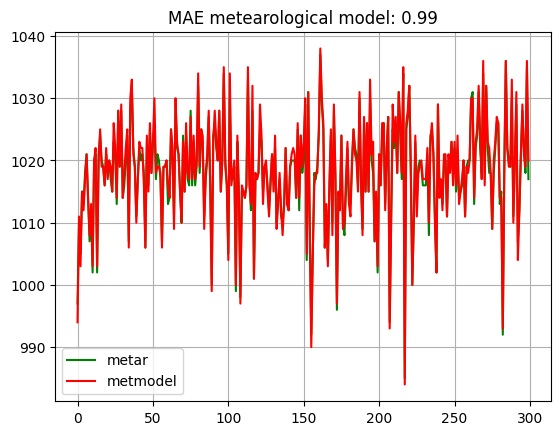

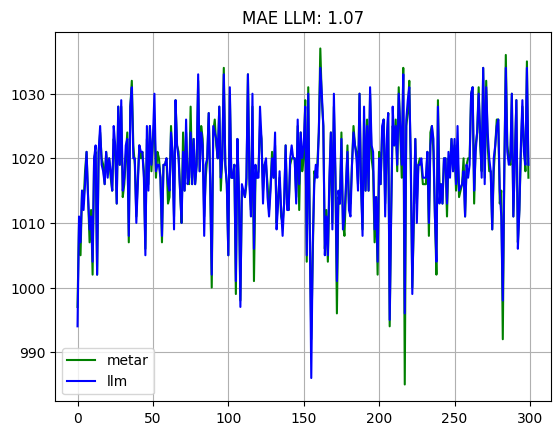

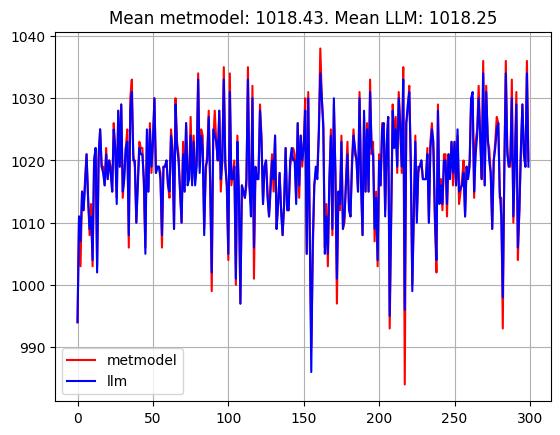

In [3]:
#@title QNH check

import pandas as pd
import numpy as np
pd.options.display.max_rows = 999

score = []

def flatten_list(list_s):
  numbers = []
  for sublist in list_s:
      for item in sublist:
          # Check if the string after 'q' is not empty
          if len(item) > 1:
              num = item[1:]
              if num.isdigit():
                  numbers.append(int(num))


  return np.array(numbers)

df = pd.read_csv(result_path)
q_ytest = []
q_ypred = []
q_metmod =[]
for i in range(0,len(df)):
  q_ytest.append([word for word in df["y_test"][i].split() if 'q' in word.lower()])
  q_ypred.append([word for word in df["y_pred"][i].split() if 'q' in word.lower()][:1])
  q_metmod.append([word for word in df["all"][i].split() if 'q' in word.lower()][:1])

q_ypred_f = []

for sublist in q_ypred:
    if not sublist:  # Check if the sublist is empty
        q_ypred_f.append(["q0000"])
    else:
        q_ypred_f.append(sublist)  # Append the single string element


q_ypred_n = flatten_list(q_ypred_f)
q_test_n = flatten_list(q_ytest)
q_metmod_n = flatten_list(q_metmod)


#Show results
df_res = pd.DataFrame({"metar":q_test_n,"metmodel":q_metmod_n,"llm":q_ypred_n})

#avoid 0
df_res = df_res[df_res.llm!=0]
mae_llm = round((df_res['metar'] - df_res['llm']).abs().mean(),2)
mae_metmod = round(np.mean(np.abs(q_metmod_n - q_test_n)),2)

score.append(mae_llm)
score.append(mae_metmod)

df_res[["metar","metmodel"]].plot(grid=True, color=['green', 'red'],title="MAE metearological model: {}".format(mae_metmod));
df_res[["metar","llm"]].plot(grid=True, color=['green', 'blue'],title="MAE LLM: {}".format(mae_llm));
df_res[["metmodel","llm"]].plot(grid=True, color=['red', 'blue'],title="Mean metmodel: {}. Mean LLM: {}".format(round(q_metmod_n.mean(),2),round(df_res.llm.mean(),2)));

In [4]:
#@title wind check

import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

pd.options.display.max_rows = 999

def contains_vrb(column):
    return column.str.contains('VRB', case=False, na=False)

def detect_wind_variation_test(metar):
    # Define a regex pattern for wind direction variation
    wind_variation_pattern = r'\b(\d{3})V(\d{3})\b'

    # Search for the wind direction variation in the METAR report
    match = re.search(wind_variation_pattern, metar)
    if match:
        dir1 = match.group(1)
        dir2 = match.group(2)
        return dir1,dir2
    else:
        return -1,-1

def detect_wind_variation_llm(metar):
    # Define a regex pattern for wind direction variation
    wind_variation_pattern = r'\b(\d{3})v(\d{3})\b'

    # Search for the wind direction variation in the METAR report
    match = re.search(wind_variation_pattern, metar)
    if match:
        dir1 = match.group(1)
        dir2 = match.group(2)
        return dir1,dir2
    else:
        return -1,-1


# Function to extract wind direction, speed, and gusts
def extract_wind_llm(metar):
    # Define a regex pattern for wind direction, intensity, and gusts
    # Also include a pattern for variable wind direction (VRB)
    wind_pattern = r'\b(vrb|\d{3})(\d{2})(g\d{2})?kt\b'

    # Search for the wind information in the METAR report
    match = re.search(wind_pattern, metar)
    if match:
        wind_direction = match.group(1)
        wind_speed = match.group(2)
        wind_gust = match.group(3) if match.group(3) else 0
        return wind_direction, wind_speed, wind_gust
    else:
        return "Wind information not found"


def extract_wind_test(metar):
    # Define a regex pattern for wind direction, intensity, and gusts
    # Also include a pattern for variable wind direction (VRB)
    wind_pattern = r'\b(VRB|\d{3})(\d{2})(G\d{2})?KT\b'

    # Search for the wind information in the METAR report
    match = re.search(wind_pattern, metar)
    if match:
        wind_direction = match.group(1)
        wind_speed = match.group(2)
        wind_gust = match.group(3) if match.group(3) else 0
        return wind_direction, wind_speed, wind_gust
    else:
        return "Wind information not found"

dirtest, modtest, gtest =[],[],[]
dirllm, modllm, gllm =[],[],[]

df = pd.read_csv(result_path)

for i in range(0,len(df)):
  wind_info_test = extract_wind_test(df["y_test"][i])
  wind_info_llm = extract_wind_llm(df["y_pred"][i])

  if isinstance(wind_info_test, tuple):
    dir, mod, gust = wind_info_test
    dirtest.append(dir)
    modtest.append(mod)
    gtest.append(gust)

  else:
    print(wind_info_test)
    dirtest.append(np.nan)
    modtest.append(np.nan)
    gtest.append(np.nan)

  if isinstance(wind_info_llm, tuple):
    dir, mod, gust = wind_info_llm
    dirllm.append(dir)
    modllm.append(mod)
    gllm.append(gust)

  else:
    print(wind_info_llm,i)
    dirllm.append(np.nan)
    modllm.append(np.nan)
    gllm.append(np.nan)

df["dirtest"]=dirtest
df["modtest"]=modtest
df["gtest"]=gtest

df["dirllm"]=dirllm
df["modllm"]=modllm
df["gllm"]=gllm

for i in range(0,len(df)):
  if "G" in str(df['gtest'][i]):
    df["gtest"][i]= int(df['gtest'][i][1:])

for i in range(0,len(df)):
  if "g" in str(df['gllm'][i]):
    df["gllm"][i]= int(df['gllm'][i][1:])

dirmetmod =[]
for i in range(0,len(df)):
  dirmetmod.append(int(df["all"][i].split()[0][:3]))
df["dirmetmod"] = dirmetmod

modmetmod =[]
for i in range(0,len(df)):
  modmetmod.append(int(df["all"][i].split()[0][3:5]))
df["modmetmod"] = modmetmod

dirvar = []
for i in range(0,len(df)):
  dirvar.append(detect_wind_variation_test(df["y_test"][i]))
df["dirvartest"] = dirvar

dirvar = []
for i in range(0,len(df)):
  dirvar.append(detect_wind_variation_llm(df["y_pred"][i]))
df["dirvarllm"] = dirvar
df.set_index("time")

#Analytics
mask_dirtest = contains_vrb(df['dirtest'])
mask_dirllm = contains_vrb(df['dirllm'])

# Combine the masks to filter rows
df_dir = df[~(mask_dirtest | mask_dirllm)][["dirtest","dirllm","dirmetmod"]].dropna().astype(int)

mae = int(np.mean(np.abs(df_dir['dirtest'] - df_dir['dirmetmod'])))
print(f"Mean Absolute Error (degrees) wind direction metmodel and metar: {mae}")
score.append(mae)
#MAE dir no vrb llm metar
mae = int((np.mean(np.abs(df_dir['dirtest'] - df_dir['dirllm']))))
print(f"Mean Absolute Error (degrees) wind direction llm and metar: {mae}")
score.append(mae)
df_mod= df[['modmetmod',"modtest","modllm"]].dropna().astype(int)

mae = round(np.mean(np.abs(df_mod['modtest'] - df_mod['modmetmod'])),2)
print(f"Mean Absolute Error (Kt) wind intensity metmodel and metar: {mae}")
score.append(mae)

#MAE dir no vrb llm metar
mae = round(np.mean(np.abs(df_mod['modtest'] - df_mod['modllm'])),2)
print(f"Mean Absolute Error (kt) wind intensity llm and metar: {mae}")
score.append(mae)

dirvary = sum([1 if (df["dirvarllm"][c][0]!=-1) & (df["dirvartest"][c][0]!=-1) else 0 for c in range(0,len(df))])
dirvarn = sum([1 if (df["dirvarllm"][c][0]==-1) & (df["dirvartest"][c][0]==-1) else 0 for c in range(0,len(df))])
print("Both metar and forecast direction variation:", round(dirvary/len(df),2))
print("Both metar and forecast no direction variation:",round(dirvarn/len(df),2))
print("No match between metar and forecast:", round((len(df)-dirvary-dirvarn)/len(df),2))

display(df.set_index("time")[["dirtest","dirllm","dirmetmod","dirvartest","dirvarllm", "modtest",	"modmetmod","modllm","gtest","gllm"]].head(20))

Wind information not found 3
Mean Absolute Error (degrees) wind direction metmodel and metar: 58
Mean Absolute Error (degrees) wind direction llm and metar: 67
Mean Absolute Error (Kt) wind intensity metmodel and metar: 2.27
Mean Absolute Error (kt) wind intensity llm and metar: 2.38
Both metar and forecast direction variation: 0.4
Both metar and forecast no direction variation: 0.34
No match between metar and forecast: 0.26


,dirtest,dirllm,dirmetmod,dirvartest,dirvarllm,modtest,modmetmod,modllm,gtest,gllm
time,,,,,,,,,,
2019-04-23 18:00:00,280,300,230,"(250, 310)","(260, 010)",10,13,09,0,0
2019-05-09 11:00:00,010,190,200,"(340, 040)","(160, 240)",03,5,09,0,0
2021-12-24 10:00:00,170,190,210,"(140, 220)","(-1, -1)",09,7,09,0,0
2019-08-17 12:00:00,200,NaN,200,"(160, 240)","(300, 080)",12,11,NaN,0,NaN
2022-04-13 04:00:00,200,270,260,"(160, 240)","(-1, -1)",04,7,06,0,0
2021-05-06 19:00:00,230,170,240,"(200, 260)","(-1, -1)",09,5,04,0,0
2019-10-02 08:00:00,220,210,230,"(190, 250)","(-1, -1)",03,5,05,0,0
2022-09-03 12:00:00,220,240,230,"(-1, -1)","(200, 260)",11,11,08,0,0
2018-12-18 07:00:00,190,220,190,"(160, 220)","(190, 250)",19,23,17,36,0


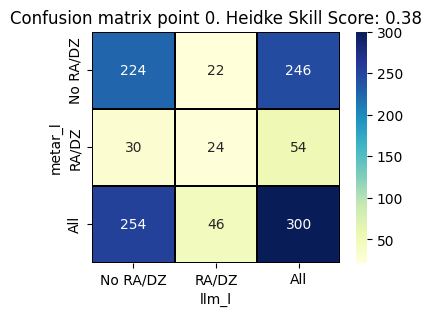

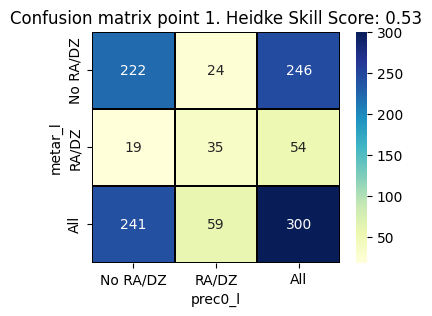

In [5]:
#@title Precipitation check

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_rows', 100)
df = pd.read_csv(result_path)

df["metar_l"] = "No RA/DZ"
mask = df['y_test'].str.contains("RA")
df.loc[mask,["metar_l"]] = "RA/DZ"
mask = df['y_test'].str.contains("DZ")
df.loc[mask,["metar_l"]] = "RA/DZ"

df["llm_l"] = "No RA/DZ"
mask = df['y_pred'].str.contains("ra")
df.loc[mask,["llm_l"]] = "RA/DZ"
mask = df['y_pred'].str.contains("dz")
df.loc[mask,["llm_l"]] = "RA/DZ"

df["prec0_l"] = "No RA/DZ"
mask = df['all'].str.contains("prec0y")
df.loc[mask,["prec0_l"]] = "RA/DZ"

# Confussion matrix and Heidke skill score
cm0 = pd.crosstab(df.metar_l, df.llm_l,margins=True)
a = cm0.values[0,0]
b = cm0.values[1,0]
c = cm0.values[0,1]
d = cm0.values[1,1]
HSS0 = round(2*(a*d-b*c)/((a+c)*(c+d)+(a+b)*(b+d)),2)
score.append(HSS0)

cm1 = pd.crosstab(df.metar_l, df.prec0_l,margins=True)
a = cm1.values[0,0]
b = cm1.values[1,0]
c = cm1.values[0,1]
d = cm1.values[1,1]
HSS1 = round(2*(a*d-b*c)/((a+c)*(c+d)+(a+b)*(b+d)),2)
score.append(HSS1)

plt.figure(figsize=(4, 3))
plt.title("Confusion matrix point 0. Heidke Skill Score: {}".format(HSS0))
seab0 = sns.heatmap(cm0,annot=True,cmap="YlGnBu",fmt='.0f',linewidths=.2,linecolor='black');
plt.show()

plt.figure(figsize=(4, 3))
plt.title("Confusion matrix point 1. Heidke Skill Score: {}".format(HSS1))
seab1 = sns.heatmap(cm1,annot=True,cmap="YlGnBu",fmt='.0f',linewidths=.2,linecolor='black');
plt.show()


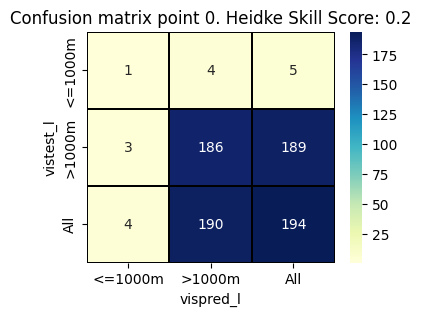

In [6]:
#@title Visibility check

import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns

pd.options.display.max_rows = 999

def extract_visibility(metar):
    # Check if 'CAVOK' is in the METAR report
    if 'CAVOK' in metar:
        return '9999'
    if "cavok" in metar:
        return "9999"
    # Define a regex pattern for visibility
    visibility_pattern = r'\b(\d{4}|(\d+/\d+)?SM)\b'

    # Search for the visibility in the METAR report
    match = re.search(visibility_pattern, metar)
    if match:
        return int(match.group(0))
    else:
        return "Visibility information not found"

df = pd.read_csv(result_path)

vistest = []
vispred = []
for i in range(0,len(df)):
  vistest.append(extract_visibility(df["y_test"][i]))
  vispred.append(extract_visibility(df["y_pred"][i]))

df["vistest"]= vistest
df["vispred"]= vispred
df[['y_test', 'y_pred', 'all', 'vistest', 'vispred']]


#visibility to interval
interval = pd.IntervalIndex.from_tuples([(-0.1,1000), (1000, 40000)])
labels = ['<=1000m', '>1000m']
df["vistest_l"] = pd.cut(df["vistest"], bins=interval,retbins=False,
                        labels=labels).map({a:b for a,b in zip(interval,labels)}).astype("category")
df["vispred_l"] = pd.cut(df["vispred"], bins=interval,retbins=False,
                        labels=labels).map({a:b for a,b in zip(interval,labels)}).astype("category")

cm0 = pd.crosstab(df.vistest_l, df.vispred_l,margins=True)
a = cm0.values[0,0]
b = cm0.values[1,0]
c = cm0.values[0,1]
d = cm0.values[1,1]
HSS0 = round(2*(a*d-b*c)/((a+c)*(c+d)+(a+b)*(b+d)),2)
score.append(HSS0)

plt.figure(figsize=(4, 3))
plt.title("Confusion matrix point 0. Heidke Skill Score: {}".format(HSS0))
seab0 = sns.heatmap(cm0,annot=True,cmap="YlGnBu",fmt='.0f',linewidths=.2,linecolor='black');
plt.show()

In [7]:
#@title Temperature check

import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def extract_temperature_test(metar):
    # Define a regex pattern to match the temperature (TT/DD)
    temperature_pattern = r'\b(M?\d{2})/(M?\d{2})\b'

    # Search for the temperature pattern in the METAR report
    match = re.search(temperature_pattern, metar)
    if match:
        temperature = match.group(1)
        if 'M' in temperature:
            temperature = -int(temperature.replace('M', ''))
        else:
            temperature = int(temperature)
        return temperature
    else:
        return None


def extract_temperature_llm(metar):
    # Define a regex pattern to match the temperature (TT/DD)
    temperature_pattern = r'\b(m?\d{2}) (m?\d{2})\b'

    # Search for the temperature pattern in the METAR report
    match = re.search(temperature_pattern, metar)
    if match:
        temperature = match.group(1)
        if 'm' in temperature:
            temperature = -int(temperature.replace('m', ''))
        else:
            temperature = int(temperature)
        return temperature
    else:
        return None


templlm,tempmetar,tempmetmod, tempmetmodraw =[],[],[],[]
for i in range (0,len(df)):
  tempmetar.append(extract_temperature_test(df["y_test"][i]))
  templlm.append(extract_temperature_llm(df["y_pred"][i]))
  tempmetmodraw.append(df["all"][i].split()[5])

tempmetmod = [-int(temperature.replace('M', '')) if 'M' in temperature else int(temperature) for temperature in tempmetmodraw]
df_temp=pd.DataFrame({"tempmetar":tempmetar,"templlm":templlm,"tempmetmod":tempmetmod}).dropna()


mae = round(np.mean(np.abs(df_temp['tempmetar'] - df_temp['tempmetmod'])),2)
std = round((df_temp['tempmetar'] - df_temp['tempmetmod']).std(),2)
print(f"Mean Absolute Error (degrees) temperature metmodel and metar: {mae}")
print(f"Standard desviation differences (degrees) temperature metmodel and metar: {std}")
score.append(mae)
score.append(std)

#MAE dir no vrb llm metar
mae = round(np.mean(np.abs(df_temp['tempmetar'] - df_temp['templlm'])),2)
std = round((df_temp['tempmetar'] - df_temp['templlm']).std(),2)
print(f"Mean Absolute Error temperature (degreees) llm and metar: {mae}")
print(f"Standard desviation differences (degrees) temperature LLM and metar: {std}")
score.append(mae)
score.append(std)
df_temp.head(20)

Mean Absolute Error (degrees) temperature metmodel and metar: 1.53
Standard desviation differences (degrees) temperature metmodel and metar: 2.01
Mean Absolute Error temperature (degreees) llm and metar: 1.6
Standard desviation differences (degrees) temperature LLM and metar: 2.17


,tempmetar,templlm,tempmetmod
0,12,9.0,13
1,11,14.0,15
2,12,13.0,13
3,24,24.0,24
4,12,12.0,12
5,17,15.0,16
6,15,15.0,14
7,24,23.0,22
8,12,14.0,14
9,11,12.0,10


In [8]:
#@title Save score

df_score = pd.DataFrame(score,index=["MAE_QNH_llm","MAE_QNH_metmodel","MAE_dir_metmodel",
                          "MAE_dir_llm","MAE_wind_int_metmodel","MAE_wind_int_llm",
                          "HSS_prec_llm","HSS_prec_metmodel","HHS_vis_llm","MAE_temp_metmodel","Std_temp_diff_metmodel",
                          "MAE_temp_llm","Std_temp_diff_metmodel"], columns=["Score"])
score_path = "/content/drive/MyDrive/Colab Notebooks/gpt/LECO/LECOscore1.csv"
df_score.to_csv(score_path)

In [9]:
df_score

,Score
MAE_QNH_llm,1.07
MAE_QNH_metmodel,0.99
MAE_dir_metmodel,58.00
MAE_dir_llm,67.00
MAE_wind_int_metmodel,2.27
MAE_wind_int_llm,2.38
HSS_prec_llm,0.38
HSS_prec_metmodel,0.53
HHS_vis_llm,0.20
MAE_temp_metmodel,1.53
